# **UTS DL Kelompok 3 - MODEL ResNet18**

- ALIF ALAMSYAH - 11220940000028
- IBNULLABIB - 11220940000037

# **Konfigurasi Awal: Random Seed dan Device**

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
from torchinfo import summary
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Untuk plotting confusion matrix yang lebih baik

# --- 1. Konfigurasi Awal: Random Seed dan Device ---
# Penjelasan:
# Bagian ini bertujuan untuk memastikan reproduktifitas eksperimen dan memilih perangkat komputasi (CPU atau GPU).

# Fungsi untuk mengatur random seed
def set_seed(seed_value=42):
    """Mengatur seed untuk reproduktifitas."""
    torch.manual_seed(seed_value) # Seed untuk PyTorch
    torch.cuda.manual_seed_all(seed_value) # Seed untuk semua GPU jika ada
    np.random.seed(seed_value) # Seed untuk NumPy
    # Jika menggunakan komponen random lain (misalnya, dari Python standar), seed juga bisa diatur.
    # Beberapa operasi CUDA mungkin tetap non-deterministik,
    # tapi ini adalah usaha terbaik untuk reproduktifitas.
    # Untuk determinisme penuh (dengan potensi penurunan performa):
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_seed(42) # Memanggil fungsi untuk mengatur seed

# Cek ketersediaan GPU dan mengatur device
# Ini akan menggunakan GPU (cuda) jika tersedia, jika tidak akan menggunakan CPU.
# Di Google Colab, pastikan Anda telah memilih runtime dengan akselerator GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# --- Hyperparameters  ---
BATCH_SIZE = 128
EPOCHS = 60 # Jumlah epoch bisa disesuaikan, 60 adalah titik awal yang baik
NUM_CLASSES = 10 # CIFAR-10 memiliki 10 kelas
LEARNING_RATE = 0.1 # Learning rate awal untuk SGD
MOMENTUM = 0.9 # Momentum untuk SGD
WEIGHT_DECAY = 5e-4 # L2 regularization

# --- Parameter untuk Early Stopping ---
PATIENCE_EARLY_STOPPING = 10 # Jumlah epoch untuk menunggu jika tidak ada peningkatan val_loss
BEST_MODEL_PATH = './best_model_early_stopping.pth' # Path untuk menyimpan model terbaik

Menggunakan device: cuda


## **Konfigurasi Awal: Random Seed dan Device**
Bagian ini sangat penting untuk reproduktifitas eksperimen dan efisiensi komputasi.

**Pengaturan Random Seed**

Fungsi set_seed(seed_value=42) bertujuan untuk memastikan bahwa setiap kali kode dijalankan, hasil yang diperoleh akan konsisten, terutama dalam hal inisialisasi bobot model, pembagian data, dan operasi lain yang melibatkan proses acak.
- `torch.manual_seed(seed_value)`: Mengatur seed untuk semua operasi acak di PyTorch baik di CPU maupun GPU.
- `torch.cuda.manual_seed_all(seed_value)`: Jika Anda menggunakan beberapa GPU, fungsi ini mengatur seed untuk semua GPU tersebut.
- `np.random.seed(seed_value)`: Mengatur seed untuk operasi acak pada library NumPy, yang mungkin digunakan dalam pra-pemrosesan data atau augmentasi.
- Opsi `torch.backends.cudnn.deterministic = True` dan `torch.backends.cudnn.benchmark = False` dapat digunakan untuk memastikan operasi cuDNN (library NVIDIA untuk deep learning) bersifat deterministik, namun ini seringkali memperlambat pelatihan. Untuk sebagian besar kasus, tiga baris pertama sudah cukup untuk reproduktifitas yang baik.

**Pemilihan Device Komputasi**

Kode ini secara otomatis mendeteksi ketersediaan GPU (khususnya NVIDIA GPU dengan CUDA) dan memilihnya jika ada. Jika tidak ada GPU yang kompatibel, maka CPU akan digunakan.
- `torch.cuda.is_available()`: Fungsi ini mengembalikan True jika PyTorch dapat mengakses GPU CUDA yang kompatibel.
- `torch.device("cuda")`: Menunjukkan bahwa operasi PyTorch akan dialokasikan dan dijalankan di GPU.
- `torch.device("cpu")`: Menunjukkan bahwa operasi PyTorch akan dialokasikan dan dijalankan di CPU.
- Menggunakan GPU (seperti di Google Colab dengan runtime GPU) akan mempercepat proses pelatihan model secara signifikan dibandingkan menggunakan CPU, terutama untuk model deep learning yang kompleks.

**Hyperparameters**

Hyperparameter adalah parameter konfigurasi yang nilainya diatur sebelum proses pelatihan dimulai dan tidak dipelajari oleh model secara langsung selama pelatihan. Pemilihan hyperparameter yang tepat sangat krusial untuk mendapatkan performa model yang baik.

- `BATCH_SIZE = 128`: Jumlah sampel data yang diproses sebelum bobot model diperbarui. Batch size yang lebih besar bisa mempercepat training per epoch dan memberikan estimasi gradien yang lebih stabil, namun membutuhkan lebih banyak memori.
- `EPOCHS = 60`: Jumlah berapa kali keseluruhan dataset training akan dilewatkan melalui model selama proses pelatihan. Nilai ini adalah titik awal dan bisa disesuaikan, terutama jika menggunakan early stopping.
- `NUM_CLASSES = 10`: Jumlah kelas output yang harus diprediksi oleh model. Untuk dataset CIFAR-10, ada 10 kelas gambar (misalnya, pesawat, mobil, burung, dll.).
- `LEARNING_RATE = 0.1`: Ukuran langkah yang diambil oleh optimizer untuk memperbarui bobot model. Learning rate yang terlalu tinggi dapat menyebabkan model tidak konvergen, sedangkan yang terlalu rendah dapat membuat pelatihan menjadi sangat lambat. Nilai 0.1 adalah learning rate awal yang umum untuk optimizer SGD dengan momentum.
- `MOMENTUM = 0.9`: Parameter untuk optimizer SGD. Momentum membantu mengakselerasi SGD ke arah yang relevan dan meredam osilasi, seringkali menghasilkan konvergensi yang lebih cepat dan lebih baik.
- `WEIGHT_DECAY = 5e-4` (atau 5×10 −4): Parameter untuk regularisasi L2. Ini menambahkan penalti ke loss function berdasarkan besarnya bobot model, yang membantu mencegah overfitting dengan mendorong model untuk memiliki bobot yang lebih kecil.

**Parameter untuk Early Stopping**

Early stopping adalah teknik regularisasi untuk mencegah overfitting dengan cara menghentikan pelatihan jika performa model pada data validasi tidak lagi membaik selama beberapa epoch tertentu.

- `PATIENCE_EARLY_STOPPING = 10`: Jumlah epoch kesabaran. Jika validation loss (atau metrik lain yang dipantau) tidak menunjukkan perbaikan (penurunan, dalam kasus loss) selama 10 epoch berturut-turut, maka pelatihan akan dihentikan lebih awal.
- `BEST_MODEL_PATH = './best_model_early_stopping.pth'`: Path (lokasi dan nama file) untuk menyimpan bobot model yang menghasilkan validation loss terbaik selama pelatihan. Ini memastikan bahwa meskipun pelatihan berhenti lebih awal atau berlanjut hingga akhir, kita tetap memiliki akses ke model dengan performa validasi terbaik.

# **Persiapan Data**

In [ ]:
# --- 2. Persiapan Data (termasuk pembagian training dan validasi) ---
# Penjelasan:
# Langkah ini mencakup pemuatan dataset CIFAR-10, pendefinisian transformasi data
# (augmentasi untuk data training, normalisasi untuk semua data), dan pembagian
# dataset training awal menjadi set training baru dan set validasi.

# Normalisasi menggunakan mean dan std dari CIFAR-10
normalize_cifar = transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                       std=(0.5, 0.5, 0.5))

# Transformasi untuk data training:
# - RandomCrop: Memotong gambar secara acak menjadi 32x32 setelah padding 4 piksel.
#               Ini membantu model menjadi lebih robust terhadap variasi posisi objek.
# - RandomHorizontalFlip: Membalik gambar secara horizontal dengan probabilitas 0.5.
#                         Ini adalah teknik augmentasi umum.
# - ToTensor: Mengkonversi gambar PIL atau NumPy array (H x W x C) menjadi FloatTensor (C x H x W)
#             dan menskalakan piksel dari [0, 255] ke [0.0, 1.0].
# - Normalize: Menormalisasi tensor gambar dengan mean dan std yang ditentukan.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_cifar,
])

# Transformasi untuk data validasi dan test:
# - Hanya ToTensor dan Normalize. Kita tidak melakukan augmentasi pada data validasi/test
#   karena kita ingin evaluasi pada data "aslinya".
transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_cifar,
])

# Memuat dataset CIFAR-10 secara keseluruhan untuk training
# download=True akan mengunduh dataset jika belum ada di folder ./data
train_full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_train)

# Memuat dataset CIFAR-10 untuk testing
test_dataset_original = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_val_test)

# Pembagian dataset training_full menjadi training dan validasi
# Kita akan menggunakan 10% dari data training_full sebagai data validasi
num_train_full = len(train_full_dataset) # Total data training awal (biasanya 50000)
val_split = 0.1 # Proporsi data validasi
num_val = int(val_split * num_train_full) # Jumlah data untuk validasi
num_train = num_train_full - num_val # Jumlah data untuk training

# Menggunakan random_split untuk membagi dataset
# Perlu diingat bahwa transform_train diterapkan pada kedua split ini.
# Idealnya, untuk val_dataset, kita mungkin ingin menggunakan transform_val_test.
# Namun, jika transform_train hanya berisi augmentasi yang tidak mengubah distribusi secara drastis,
# ini masih bisa diterima. Untuk praktik terbaik, kita bisa membuat Subset dan menerapkan transform berbeda.
# Di sini, untuk kesederhanaan, kita akan menggunakan transform_train untuk kedua split,
# atau lebih baik, kita buat dataset dengan transform yang sesuai.

# Untuk memastikan transform yang tepat, kita buat ulang dataset untuk split validasi
# dengan transform_val_test.
train_dataset_indices, val_dataset_indices = random_split(range(num_train_full), [num_train, num_val])

# Buat dataset training dengan transform_train
train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train),
    train_dataset_indices.indices
)

# Buat dataset validasi dengan transform_val_test
val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_val_test),
    val_dataset_indices.indices
)


# Membuat DataLoaders
# DataLoader menggabungkan dataset dan sampler, dan menyediakan iterator iterable
# atas dataset tersebut.
# - batch_size: Jumlah sampel per batch.
# - shuffle: Apakah akan mengacak data di setiap epoch (True untuk training, False untuk validasi/test).
# - num_workers: Jumlah subprocess untuk pemuatan data. Meningkatkan ini bisa mempercepat
#                pemuatan data, terutama jika ada bottleneck di CPU. Di Colab, 2 seringkali cukup.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset_original, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Nama kelas untuk referensi
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Jumlah data training: {len(train_dataset)}")
print(f"Jumlah data validasi: {len(val_dataset)}")
print(f"Jumlah data test: {len(test_dataset_original)}")

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Jumlah data training: 45000
Jumlah data validasi: 5000
Jumlah data test: 10000


**Normalisasi Gambar**

Gambar dinormalisasi agar memiliki rentang nilai piksel yang seragam. Ini membantu proses training menjadi lebih stabil.
- `transforms.Normalize`: Fungsi ini menormalisasi tensor gambar. Untuk setiap channel gambar, nilai piksel x diubah menjadi (x−mean)/std.
- `mean=(0.5, 0.5, 0.5) dan std=(0.5, 0.5, 0.5)`: Nilai rata-rata dan standar deviasi yang digunakan untuk normalisasi masing-masing channel Red, Green, Blue (RGB). Menggunakan mean 0.5 dan std 0.5 akan mengubah rentang piksel [0, 1] menjadi [-1, 1]. Catatan: Nilai mean dan std yang lebih presisi untuk CIFAR-10 adalah mean=(0.4914, 0.4822, 0.4465) dan std=(0.2023, 0.1994, 0.2010). Menggunakan nilai 0.5 juga umum dan bisa bekerja dengan baik.

**Transformasi Data**

Transformasi data berbeda diterapkan untuk set training dan set validasi/test.

Untuk Data Training:

Dilakukan augmentasi data untuk meningkatkan variasi data training, yang membantu model melakukan generalisasi lebih baik dan mengurangi overfitting.
transforms.Compose: Menggabungkan beberapa langkah transformasi menjadi satu pipeline.
- `transforms.RandomCrop(32, padding=4)`: Menambahkan padding 4 piksel di sekeliling gambar, kemudian memotong gambar secara acak menjadi ukuran 32x32 piksel.
- `transforms.RandomHorizontalFlip()`: Membalik gambar secara horizontal dengan probabilitas 0.5 (default).
- `transforms.ToTensor()`: Mengonversi gambar dari format PIL Image atau NumPy array (dengan rentang piksel 0-255) menjadi PyTorch FloatTensor (dengan rentang piksel 0.0-1.0) dan mengubah urutan dimensi dari HxWxL (Height, Width, Channel) menjadi LxHxW (Channel, Height, Width).
- `normalize_cifar`: Menerapkan normalisasi yang telah didefinisikan sebelumnya.

Untuk Data Validasi dan Test:

Tidak ada augmentasi yang diterapkan karena kita ingin mengevaluasi model pada data "asli" tanpa modifikasi acak.

**Memuat dan Membagi Dataset**

Dataset CIFAR-10 dimuat dan kemudian dibagi menjadi set training, validasi, dan test.

1. Pemuatan Dataset Awal:
  - `torchvision.datasets.CIFAR10`: Memuat dataset CIFAR-10.
  - `root='./data'`: Lokasi penyimpanan dataset.
  - `train=True`: Memuat bagian training dari dataset.
  - `train=False`: Memuat bagian test dari dataset.
  download=True: Akan mengunduh dataset jika belum ada di `root`.
  - `transform`: Menerapkan transformasi yang telah didefinisikan. Penting: Pada kode ini, `train_full_dataset` langsung diberi `transform_train`. Ini berarti saat dibagi nanti, subset validasi juga akan memiliki augmentasi jika tidak ditangani dengan benar.

2.  Pembagian Data Training menjadi Training dan Validasi:

  Sebagian kecil dari data training (val_split = 0.1 atau 10%) dipisahkan untuk menjadi set validasi. Set validasi digunakan untuk memonitor performa model selama pelatihan (misalnya untuk early stopping) tanpa "mencemari" set test.
    - `random_split`: Membagi dataset (atau dalam hal ini, range indeks) secara acak menjadi dua bagian dengan ukuran yang ditentukan.

3. Pembuatan Subset dengan Transformasi yang Tepat:

  Untuk memastikan set validasi tidak terkena augmentasi dari `transform_train`, dataset CIFAR-10 dimuat ulang (kali ini dengan `transform=None` untuk `download=False` karena data sudah ada) dan kemudian Subset dibuat dengan transformasi yang sesuai untuk masing-masing bagian.
  - `Subset`: Objek yang merepresentasikan sebagian dari dataset asli, menggunakan indeks yang telah ditentukan. Ini memungkinkan penerapan transformasi yang berbeda pada bagian training dan validasi meskipun berasal dari `train=True` yang sama.

**Membuat** `DataLoader`

DataLoader adalah iterator yang menyediakan data dalam bentuk batch ke model selama pelatihan dan evaluasi. Ini juga menangani pengacakan data dan pemuatan data secara paralel.

- `DataLoader`: Kelas PyTorch untuk memuat data.
- `batch_size=BATCH_SIZE`: Menggunakan `BATCH_SIZE` yang telah didefinisikan sebelumnya (128).
- `shuffle=True` (untuk `train_loader`): Mengacak urutan data di setiap epoch agar model tidak mempelajari urutan data.
- `shuffle=False` (untuk `val_loader` dan `test_loader`): Urutan data tidak perlu diacak untuk evaluasi.
- `num_workers=2`: Jumlah proses tambahan yang digunakan untuk memuat data secara paralel. Ini dapat mempercepat pemuatan data, terutama jika ada pra-pemrosesan yang signifikan.


# **Definisi Model ResNet untuk dataset CIFAR-10**

In [ ]:
# --- 3. Definisi Model ---
# Penjelasan:
# Di sini kita mendefinisikan arsitektur model. Kita akan menggunakan ResNet18
# dan memodifikasinya agar sesuai dengan dataset CIFAR-10 (gambar 32x32).

def get_model(num_classes=NUM_CLASSES):
    """
    Memuat model ResNet18 dan memodifikasinya untuk CIFAR-10.
    """
    # Menggunakan weights=None untuk melatih dari awal (scratch).
    # Di torchvision versi lama, ini sama dengan pretrained=False.
    model = models.resnet18(weights=None)

    # Penyesuaian untuk CIFAR-10:
    # 1. Modifikasi layer konvolusi pertama (conv1)
    #    Input gambar CIFAR-10 adalah 32x32, bukan 224x224 seperti ImageNet.
    #    Kernel 7x7 dengan stride 2 terlalu agresif untuk gambar kecil ini.
    #    Kita ganti dengan kernel 3x3 dan stride 1.
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    # 2. Hapus/ganti MaxPool awal
    #    Layer MaxPool asli setelah conv1 (stride 2) juga akan mengurangi dimensi terlalu cepat.
    #    Menggantinya dengan nn.Identity() berarti layer ini tidak akan melakukan operasi apa pun.
    model.maxpool = nn.Identity()

    # 3. Modifikasi layer fully connected terakhir (classifier)
    #    ResNet18 asli dilatih untuk 1000 kelas ImageNet.
    #    Kita perlu mengganti output layer agar sesuai dengan jumlah kelas CIFAR-10.
    num_ftrs = model.fc.in_features # Dapatkan jumlah fitur input ke layer fc
    model.fc = nn.Linear(num_ftrs, num_classes) # Ganti dengan layer Linear baru

    return model

model = get_model(NUM_CLASSES) # Membuat instance model
model = model.to(device) # Memindahkan model ke device (GPU/CPU)

print("Arsitektur model ResNet18 yang telah dimodifikasi (awal):")
# print(model) # Uncomment untuk melihat detail arsitektur lengkap

Arsitektur model ResNet18 yang telah dimodifikasi (awal):


Kode ini mendefinisikan cara membuat dan menyesuaikan model ResNet18 agar cocok untuk mengklasifikasikan gambar dari dataset CIFAR-10. ResNet18 adalah arsitektur deep learning yang cukup populer dan dikenal baik untuk tugas pengenalan gambar.


1. **Ambil ResNet18 Kosongan**: Kita pakai arsitektur ResNet18, tapi kita akan melatihnya dari awal khusus untuk CIFAR-10, jadi tidak pakai bobot yang sudah ada (`weights=None`).
2. **Sesuaikan Bagian Depan**:
  - `model.conv1`: Layer paling depan yang "melihat" gambar pertama kali diubah. Kernelnya dikecilkan dan langkahnya (stride) juga, biar cocok sama gambar CIFAR-10 yang kecil (32x32 piksel). Kalau pakai settingan asli ResNet, gambar akan jadi terlalu kecil terlalu cepat.
  - `model.maxpool`: Layer Max Pooling setelah `conv1` juga dihilangkan (diganti `nn.Identity()`) karena alasan yang sama, yaitu menjaga agar ukuran fitur tidak menyusut terlalu cepat.
3. **Sesuaikan Bagian Belakang**:
  - `model.fc`: Layer fully connected (FC) atau "kepala" model yang bertugas menebak kelas gambar diubah. ResNet18 asli punya 1000 output (untuk dataset ImageNet). Karena CIFAR-10 cuma punya 10 kelas (pesawat, mobil, kucing, dll.), maka outputnya diubah jadi 10.
4. **Pindah ke GPU/CPU**: Model yang sudah jadi kemudian dipindahkan ke perangkat komputasi yang tersedia (device), entah itu GPU (untuk perhitungan cepat) atau CPU.

Singkatnya, kita mengambil "cetakan biru" ResNet18, lalu sedikit "memodifikasi" beberapa bagiannya agar lebih pas dan optimal untuk dataset CIFAR-10 yang gambarnya kecil.

# **Fungsi Pelatihan dan Evaluasi**

In [ ]:
# --- 4. Fungsi Pelatihan dan Evaluasi ---
# Penjelasan:
# Mendefinisikan fungsi terpisah untuk satu epoch pelatihan dan untuk evaluasi model.
# Ini membuat loop training utama lebih bersih dan modular.

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Melatih model untuk satu epoch."""
    model.train() # Set model ke mode training (mengaktifkan dropout, batchnorm update, dll.)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterasi melalui batch data dari dataloader
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) # Pindahkan data ke device

        optimizer.zero_grad() # Nol-kan gradien dari iterasi sebelumnya

        outputs = model(inputs) # Forward pass: dapatkan prediksi model
        loss = criterion(outputs, labels) # Hitung loss

        loss.backward() # Backward pass: hitung gradien loss terhadap parameter model
        optimizer.step() # Update bobot model berdasarkan gradien

        running_loss += loss.item() * inputs.size(0) # Akumulasi loss (dikalikan batch size untuk rata-rata yang benar)
        _, predicted = torch.max(outputs.data, 1) # Dapatkan kelas dengan probabilitas tertinggi
        total_samples += labels.size(0) # Jumlah sampel dalam batch ini
        correct_predictions += (predicted == labels).sum().item() # Jumlah prediksi yang benar

    epoch_loss = running_loss / total_samples # Rata-rata loss per sampel
    epoch_acc = 100.0 * correct_predictions / total_samples # Akurasi epoch
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device):
    """Mengevaluasi model pada dataset yang diberikan."""
    model.eval() # Set model ke mode evaluasi (menonaktifkan dropout, batchnorm tidak diupdate)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Nonaktifkan perhitungan gradien selama evaluasi
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy()) # Kumpulkan prediksi
            all_labels.extend(labels.cpu().numpy()) # Kumpulkan label sebenarnya

    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_preds, all_labels

Fungsi `train_epoch`

Fungsi `train_epoch` bertugas untuk menjalankan satu siklus pelatihan penuh (satu epoch) pada seluruh dataset pelatihan.

- Parameter:
  - `model`: Model PyTorch yang akan dilatih.
  - `dataloader`: DataLoader PyTorch yang menyediakan batch data pelatihan.
  - `criterion`: Fungsi loss (misalnya, `nn.CrossEntropyLoss`) yang mengukur seberapa baik prediksi model dibandingkan dengan label sebenarnya.
  - `optimizer`: Algoritma optimasi (misalnya, `optim.Adam`) yang mengupdate bobot model.
  - device: Perangkat (CPU atau GPU) tempat komputasi akan dilakukan (`'cuda'` atau `'cpu'`).
  - `model.train()`: Baris ini sangat penting. Ini memberitahu model PyTorch bahwa ia sedang dalam mode pelatihan. Dalam mode ini, lapisan-lapisan seperti Dropout dan Batch Normalization akan aktif dan berfungsi sebagaimana mestinya selama pelatihan (misalnya, Dropout akan secara acak menonaktifkan neuron, dan Batch Normalization akan mengupdate statistik rata-rata dan variansnya).

- Inisialisasi variabel:
  - `running_loss`: Untuk mengakumulasi total loss selama epoch.
  - `correct_predictions`: Untuk menghitung jumlah prediksi yang benar.
  - `total_samples`: Untuk menghitung jumlah total sampel yang telah diproses.

- f`or inputs, labels in dataloader`: Loop ini mengiterasi setiap batch data yang disediakan oleh `dataloader`. Setiap batch terdiri dari inputs (data fitur) dan `labels` (label target).
- `optimizer.zero_grad()`: Sebelum menghitung gradien baru (backward pass), gradien dari iterasi (batch) sebelumnya harus di-nol-kan. Jika tidak, gradien akan terakumulasi, yang akan mengganggu proses pembelajaran.

- `outputs = model(inputs)`: Ini adalah forward pass. Data input dilewatkan melalui model untuk menghasilkan `outputs` (prediksi).
- `loss = criterion(outputs, labels)`: Loss dihitung dengan membandingkan `outputs` model dengan `labels` yang sebenarnya menggunakan fungsi `criterion` yang telah ditentukan.
- loss.backward(): Ini adalah backward pass. PyTorch secara otomatis menghitung gradien dari loss terhadap setiap parameter model yang dapat dipelajari (yang memiliki `requires_grad=True`).
- `optimizer.step()`: Berdasarkan gradien yang dihitung pada langkah `loss.backward()`, optimizer mengupdate bobot model sesuai dengan aturan algoritma optimasi yang digunakan (misalnya, Adam, SGD).
- `running_loss += loss.item() * inputs.size(0)`:
  - `loss.item()`: Mengambil nilai skalar dari tensor loss (yang biasanya berisi satu elemen).
  - `inputs.size(0)`: Mendapatkan ukuran batch (jumlah sampel dalam batch saat ini).
  - Mengakumulasi loss yang dikalikan dengan ukuran batch. Ini dilakukan agar nantinya bisa dihitung rata-rata loss per sampel dengan benar, bahkan jika ukuran batch terakhir berbeda.
- `_, predicted = torch.max(outputs.data, 1)`:
  - `torch.max(outputs.data, 1)`: Untuk setiap sampel dalam batch, fungsi ini mencari nilai probabilitas tertinggi di antara semua kelas (dimensi 1 dari `outputs`). Ia mengembalikan dua tensor: nilai maksimum (yang kita abaikan dengan` _`) dan indeks dari nilai maksimum tersebut (yang merupakan kelas prediksi).
- `total_samples += labels.size(0)`: Menambahkan jumlah sampel dalam batch saat ini ke total_samples.
- `correct_predictions += (predicted == labels).sum().item()`:
  - `(predicted == labels)`: Melakukan perbandingan elemen-demi-elemen antara kelas prediksi dan label sebenarnya, menghasilkan tensor Boolean.
  - `.sum()`: Menjumlahkan semua nilai True (yang dihitung sebagai 1) untuk mendapatkan jumlah prediksi yang benar dalam batch tersebut.
  - `.item()`: Mengonversi hasil penjumlahan tensor menjadi angka Python biasa.
- `epoch_loss = running_loss / total_samples`: Menghitung rata-rata loss untuk seluruh epoch.
- `epoch_acc = 100.0 * correct_predictions / total_samples`: Menghitung akurasi pelatihan untuk epoch tersebut sebagai persentase.
- `return epoch_loss, epoch_acc`: Fungsi mengembalikan rata-rata loss dan akurasi untuk epoch pelatihan tersebut.

---

**Fungsi evaluate_model**

Fungsi `evaluate_model` digunakan untuk menilai performa model pada dataset tertentu (biasanya dataset validasi atau pengujian) tanpa melakukan pembaruan bobot.
- **Parameter**: Sama seperti train_epoch, kecuali tidak memerlukan `optimizer` karena tidak ada pembaruan bobot yang terjadi.
- model.eval(): Ini juga sangat penting. Ini memberitahu model PyTorch bahwa ia sedang dalam mode evaluasi. Dalam mode ini:
  - Lapisan Dropout dinonaktifkan (tidak ada neuron yang di-drop).
  - Lapisan Batch Normalization menggunakan statistik rata-rata dan varians yang telah dipelajari selama pelatihan dan tidak mengupdate statistiknya berdasarkan batch saat ini.
  - Hal ini memastikan perilaku model konsisten dan deterministik selama evaluasi.

- Inisialisasi variabel: Mirip dengan train_epoch, tetapi dengan tambahan:
  - `all_preds`: Daftar untuk menyimpan semua prediksi yang dibuat oleh model.
  - `all_labels`: Daftar untuk menyimpan semua label sebenarnya. Ini berguna jika Anda ingin melakukan analisis lebih lanjut seperti membuat confusion matrix.

- `with torch.no_grad()`: Blok konteks ini menonaktifkan penghitungan gradien. Selama evaluasi, kita tidak perlu menghitung gradien karena kita tidak akan melakukan backward pass atau mengupdate bobot model. Menonaktifkan gradien dapat mengurangi penggunaan memori dan mempercepat komputasi.
- Loop ini dan operasi di dalamnya (memindahkan data ke `device`, forward pass, perhitungan loss, akumulasi loss, dan perhitungan prediksi yang benar) sangat mirip dengan yang ada di train_epoch. Perbedaan utamanya adalah ini semua terjadi di dalam blok `torch.no_grad()` dan tidak ada `optimizer.zero_grad()`, `loss.backward()`, atau `optimizer.step()`.
- Mengumpulkan prediksi dan label:
  - `predicted.cpu().numpy()`: Sebelum menambahkan ke daftar Python, tensor `predicted` (yang mungkin ada di GPU) dipindahkan ke CPU (`.cpu()`) dan kemudian dikonversi menjadi array NumPy (`.numpy()`). Ini adalah praktik umum karena banyak pustaka Python (seperti scikit-learn untuk metrik evaluasi) bekerja dengan array NumPy atau daftar Python standar.
  - `all_preds.extend(...)` dan `all_labels.extend(...)`: Menambahkan prediksi dan label dari batch saat ini ke daftar keseluruhan.
- Menghitung rata-rata loss dan akurasi untuk epoch evaluasi, sama seperti pada fungsi pelatihan.
- `return epoch_loss, epoch_acc, all_preds, all_labels`: Fungsi mengembalikan rata-rata loss, akurasi, serta daftar semua prediksi dan label sebenarnya dari proses evaluasi.

# **Menjalankan Eksperimen Tuning**

In [ ]:
# --- 5. Menjalankan Eksperimen (Loop Training Utama) ---
# Penjelasan:
# Di sinilah proses training sebenarnya terjadi. Kita akan menginisialisasi
# loss function, optimizer, dan learning rate scheduler. Kemudian, kita akan
# melakukan loop sebanyak EPOCHS, memanggil fungsi train_epoch dan evaluate_model.

# Inisialisasi Loss Function
# CrossEntropyLoss cocok untuk masalah klasifikasi multi-kelas.
# Ini sudah menggabungkan LogSoftmax dan NLLLoss.
criterion = nn.CrossEntropyLoss()

# Inisialisasi Optimizer
# SGD (Stochastic Gradient Descent) dengan momentum adalah pilihan umum untuk ResNet.
# - model.parameters(): Parameter model yang akan dioptimasi.
# - lr: Learning rate.
# - momentum: Membantu optimizer melewati local minima dan mempercepat konvergensi.
# - weight_decay: Regularisasi L2 untuk mencegah overfitting.
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning Rate Scheduler (opsional tapi direkomendasikan)
# CosineAnnealingLR secara bertahap mengurangi learning rate mengikuti kurva kosinus.
# T_max adalah jumlah iterasi (epoch dalam kasus ini) sebelum LR mencapai minimum.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# Alternatif yang juga populer untuk ResNet: MultiStepLR
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[round(EPOCHS*0.5), round(EPOCHS*0.75)], gamma=0.1)

# List untuk menyimpan histori loss dan akurasi
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Variabel untuk Early Stopping
best_val_loss = float('inf') # Inisialisasi dengan nilai loss yang sangat tinggi
epochs_no_improve = 0 # Counter untuk epoch tanpa peningkatan
early_stop_triggered = False # Flag apakah early stopping terpicu

print("\nMemulai pelatihan...")
for epoch in range(EPOCHS):
    # Pelatihan model untuk satu epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Evaluasi model pada data validasi
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Cetak statistik epoch
    print(f'Epoch [{epoch+1}/{EPOCHS}]: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% - '
          f'LR: {optimizer.param_groups[0]["lr"]:.5f}')

    # Update learning rate berdasarkan scheduler
    scheduler.step()

    # Logika Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0 # Reset counter karena ada peningkatan
        # Simpan model terbaik
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'    Val loss membaik, menyimpan model ke {BEST_MODEL_PATH}')
    else:
        epochs_no_improve += 1
        print(f'    Val loss tidak membaik selama {epochs_no_improve} epoch(s).')

    if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
        print(f'\nEarly stopping terpicu setelah {epoch+1} epochs karena val_loss tidak membaik selama {PATIENCE_EARLY_STOPPING} epoch.')
        early_stop_triggered = True
        break # Hentikan loop pelatihan

if not early_stop_triggered:
    print('Pelatihan Selesai (mencapai EPOCHS maksimum).')
else:
    print('Pelatihan dihentikan lebih awal oleh Early Stopping.')

# Muat model terbaik yang disimpan jika early stopping terpicu atau jika pelatihan selesai normal
# (jika pelatihan selesai normal, BEST_MODEL_PATH akan berisi model dari epoch dengan val_loss terbaik)
if os.path.exists(BEST_MODEL_PATH):
    print(f"\nMemuat model terbaik dari: {BEST_MODEL_PATH} untuk evaluasi akhir.")
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model = model.to(device) # Pastikan model ada di device yang benar
else:
    print("\nTidak ada model terbaik yang disimpan (kemungkinan pelatihan dihentikan sangat awal atau ada masalah). Menggunakan model terakhir.")

# Contoh untuk menyimpan model (opsional)
# PATH = './cifar10_resnet18_colab_template.pth'
# torch.save(model.state_dict(), PATH) # Menyimpan hanya state dictionary (bobot) model
# print(f"Model disimpan sebagai {PATH}")
# Untuk memuat:
# model_loaded = get_model(NUM_CLASSES)
# model_loaded.load_state_dict(torch.load(PATH))
# model_loaded.to(device)
# model_loaded.eval()


Memulai pelatihan...
Epoch [1/60]: Train Loss: 2.0258, Train Acc: 27.59%, Val Loss: 1.7420, Val Acc: 36.82% - LR: 0.10000
    Val loss membaik, menyimpan model ke ./best_model_early_stopping.pth
Epoch [2/60]: Train Loss: 1.4146, Train Acc: 48.12%, Val Loss: 1.3363, Val Acc: 51.62% - LR: 0.09993
    Val loss membaik, menyimpan model ke ./best_model_early_stopping.pth
Epoch [3/60]: Train Loss: 1.1491, Train Acc: 58.46%, Val Loss: 0.9928, Val Acc: 64.92% - LR: 0.09973
    Val loss membaik, menyimpan model ke ./best_model_early_stopping.pth
Epoch [4/60]: Train Loss: 0.9492, Train Acc: 66.11%, Val Loss: 0.8810, Val Acc: 68.64% - LR: 0.09938
    Val loss membaik, menyimpan model ke ./best_model_early_stopping.pth
Epoch [5/60]: Train Loss: 0.8055, Train Acc: 71.46%, Val Loss: 0.8015, Val Acc: 71.44% - LR: 0.09891
    Val loss membaik, menyimpan model ke ./best_model_early_stopping.pth
Epoch [6/60]: Train Loss: 0.6945, Train Acc: 75.80%, Val Loss: 0.8031, Val Acc: 73.12% - LR: 0.09830
    Val

**Penjelasan Kode Menjalankan Eksperimen (Loop Training Utama)**
Bagian kode ini merupakan inti dari proses pelatihan model deep learning. Di sini, semua komponen yang telah disiapkan sebelumnya (model, data, fungsi pelatihan/evaluasi) digunakan secara bersamaan.

1. **Inisialisasi Komponen Pelatihan**
Sebelum memulai loop pelatihan, beberapa komponen penting diinisialisasi:

- `criterion = nn.CrossEntropyLoss()`:

  - Mendefinisikan loss function. `CrossEntropyLoss` adalah pilihan standar untuk masalah klasifikasi multi-kelas. Fungsi ini sudah mencakup `LogSoftmax` dan `NLLLoss` secara internal, sehingga output dari model tidak perlu melalui lapisan `Softmax` secara eksplisit sebelum dihitung loss-nya.
- `optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)`:

  - Menginisialisasi optimizer. `SGD` (Stochastic Gradient Descent) digunakan di sini.
    - `model.parameters()`: Memberitahu optimizer parameter mana dari model yang perlu dioptimasi (diperbarui bobotnya).
    - `lr=LEARNING_RATE`: Menetapkan learning rate awal.
    - `momentum=MOMENTUM`: Menerapkan momentum yang membantu optimizer berakselerasi ke arah gradien yang konsisten dan meredam osilasi, seringkali mempercepat konvergensi dan membantu melewati local minima.
    - `weight_decay=WEIGHT_DECAY`: Menerapkan regularisasi L2 (penalti pada besarnya bobot) untuk membantu mencegah overfitting.

- `scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)`:

  - Menginisialisasi learning rate scheduler. Ini adalah teknik untuk menyesuaikan learning rate secara dinamis selama pelatihan.
  - `CosineAnnealingLR`: Mengurangi learning rate dari nilai awalnya hingga mendekati nol mengikuti kurva kosinus selama `T_max` epoch. Ini dapat membantu model untuk lebih stabil dan menemukan minima yang lebih baik di akhir pelatihan.
  - Alternatif seperti `MultiStepLR` juga disebutkan, yang mengurangi LR pada epoch tertentu (milestones).

- `history = {'train_loss': [], ...}`:
  - Sebuah kamus (dictionary) untuk menyimpan nilai loss dan akurasi dari setiap epoch, baik untuk data pelatihan (`train_loss`, `train_acc`) maupun data validasi (`val_loss`, `val_acc`). Ini berguna untuk memantau kemajuan pelatihan dan memvisualisasikan kurva pembelajaran nanti.

- **Variabel untuk Early Stopping**:

  - `best_val_loss = float('inf')`: Menyimpan validation loss terbaik yang pernah dicapai. Diinisialisasi dengan tak terhingga agar loss pertama selalu lebih baik.
  - `epochs_no_improve = 0`: Penghitung berapa banyak epoch berturut-turut validation loss tidak membaik.
  - `early_stop_triggered = False: Flag` untuk menandai apakah early stopping telah diaktifkan.

2. Loop Pelatihan Utama (`for epoch in range(EPOCHS):`)
Ini adalah loop utama di mana model dilatih iterasi demi iterasi (epoch demi epoch).

- `train_loss, train_acc = train_epoch(...)`:
  - Memanggil fungsi `train_epoch` (yang telah dijelaskan sebelumnya) untuk melatih model pada data pelatihan selama satu epoch.
  - Hasil loss dan akurasi pelatihan disimpan dalam `history`.

- `val_loss, val_acc, _, _ = evaluate_model(...)`:
  - Memanggil fungsi `evaluate_model` (yang juga telah dijelaskan) untuk mengevaluasi performa model pada data validasi.
  - Hasil loss dan akurasi validasi disimpan dalam `history`. Prediksi (`_`) dan label (`_`) dari `evaluate_model` diabaikan di sini karena tidak langsung digunakan dalam loop ini.

- `print(f'Epoch [{epoch+1}/{EPOCHS}]: ...')`:
  - Mencetak statistik untuk epoch saat ini, termasuk loss dan akurasi pelatihan, loss dan akurasi validasi, serta learning rate saat ini. Ini membantu memantau proses pelatihan secara real-time.

- `scheduler.step()`:
  - Memanggil metode `step()` dari scheduler untuk memperbarui learning rate sesuai dengan strategi yang telah ditentukan (misalnya, Cosine Annealing). Ini biasanya dilakukan sekali per epoch.

3. **Logika Early Stopping**
Early stopping adalah teknik regularisasi yang menghentikan pelatihan jika performa model pada data validasi tidak lagi membaik selama beberapa epoch berturut-turut (ditentukan oleh ``PATIENCE_EARLY_STOPPING``). Ini membantu mencegah overfitting dan menghemat waktu komputasi.

- `if val_loss < best_val_loss:`:
  - Memeriksa apakah validation loss saat ini lebih baik (lebih rendah) daripada `best_val_loss` yang pernah tercatat.
  - Jika ya, `best_val_loss` diperbarui, `epochs_no_improve` direset menjadi 0, dan model saat ini (yang merupakan model terbaik sejauh ini) disimpan menggunakan `torch.save(model.state_dict(), BEST_MODEL_PATH)`. `model.state_dict()` menyimpan parameter (bobot) model yang dapat dipelajari.

- `else: epochs_no_improve += 1`:
  - Jika validation loss tidak membaik, `epochs_no_improve` ditingkatkan.

- `if epochs_no_improve >= PATIENCE_EARLY_STOPPING:`:
  - Jika `epochs_no_improve` mencapai batas kesabaran (`PATIENCE_EARLY_STOPPING`), maka early stopping dipicu.
  - Pesan dicetak, `early_stop_triggered` diatur ke `True`, dan loop pelatihan dihentikan dengan break.

4. Setelah Pelatihan Selesai
Setelah loop pelatihan selesai (baik karena mencapai EPOCHS maksimum atau karena early stopping):

- Pesan dicetak untuk menginformasikan status penyelesaian pelatihan.

- **Memuat Model Terbaik**:
  - `if os.path.exists(BEST_MODEL_PATH):`: Kode memeriksa apakah file model terbaik (`BEST_MODEL_PATH`) ada (artinya, setidaknya satu kali validation loss membaik dan model disimpan).
  - `model.load_state_dict(torch.load(BEST_MODEL_PATH))`: Jika ada, bobot model terbaik dimuat kembali ke dalam `model`. Ini memastikan bahwa model yang digunakan untuk evaluasi akhir adalah model dengan performa validasi terbaik, bukan model dari epoch terakhir (yang mungkin sudah mulai overfitting).
  - `model = model.to(device)`: Memastikan model berada di perangkat yang benar (CPU/GPU) setelah dimuat.
  - Jika `BEST_MODEL_PATH` tidak ditemukan, pesan akan ditampilkan, dan model terakhir dari pelatihan akan digunakan.

- **Contoh Menyimpan Model (Dikomentari)**:

  - Bagian yang dikomentari menunjukkan cara menyimpan state dictionary model secara manual ke path tertentu dan cara memuatnya kembali. Ini berguna jika Anda ingin menyimpan model final secara eksplisit di luar logika early stopping.

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

# **Plotting Loss dan Akurasi**

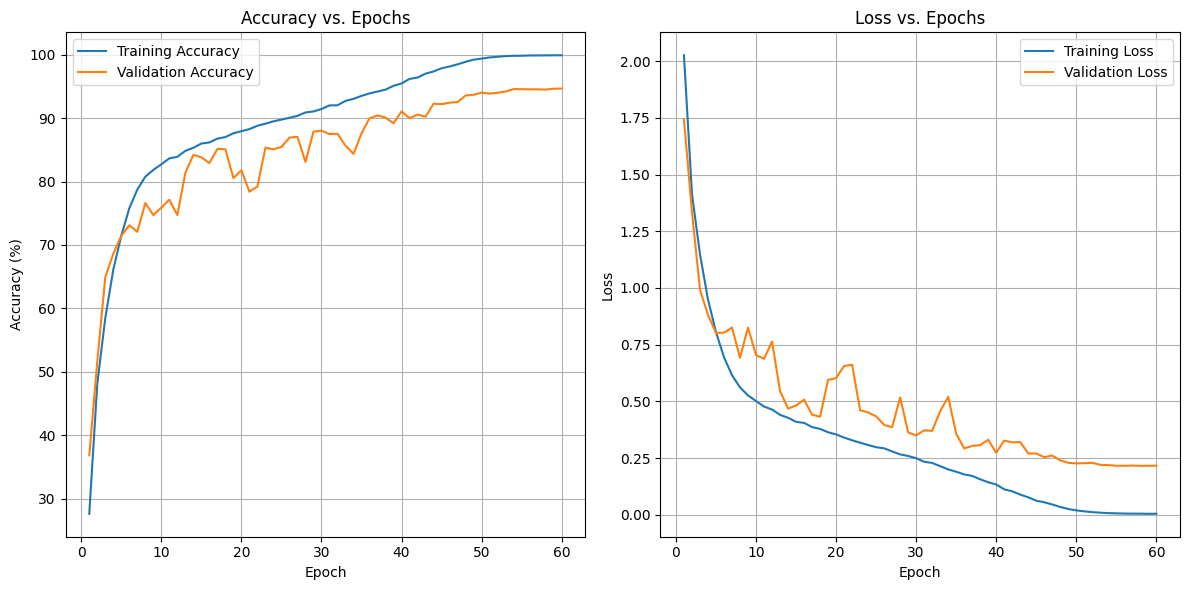

In [ ]:
# --- 6. Plotting Loss dan Akurasi ---
# Penjelasan:
# Visualisasi performa model selama training (loss dan akurasi)
# pada data training dan validasi. Ini membantu dalam mendiagnosis
# masalah seperti overfitting atau underfitting.

plt.figure(figsize=(12, 6)) # Ukuran figure plot

# Plot Akurasi
plt.subplot(1, 2, 1) # subplot 1 baris, 2 kolom, plot ke-1
plt.plot(np.arange(1, EPOCHS + 1), history['train_acc'], label='Training Accuracy')
plt.plot(np.arange(1, EPOCHS + 1), history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend() # Tampilkan legenda
plt.grid(True) # Tampilkan grid

# Plot Loss
plt.subplot(1, 2, 2) # subplot 1 baris, 2 kolom, plot ke-2
plt.plot(np.arange(1, EPOCHS + 1), history['train_loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Menyesuaikan layout agar tidak tumpang tindih
plt.show() # Tampilkan plot

- Model ResNet18 yang dimodifikasi ini belajar dengan baik untuk mengklasifikasikan dataset CIFAR-10, ditunjukkan dengan akurasi validasi yang mencapai sekitar 94-95%.
- Ada indikasi terjadinya sedikit overfitting, di mana performa model pada data training lebih baik secara signifikan dibandingkan pada data validasi.
- Pelatihan tampaknya sudah cukup konvergen menjelang epoch ke-60, karena kurva validasi (baik akurasi maupun loss) sudah relatif mendatar dan tidak menunjukkan peningkatan atau penurunan performa yang signifikan lagi.
- Fluktuasi pada kurva validasi, terutama pada loss, mungkin disebabkan oleh variasi dalam batch data validasi atau karena model mulai kesulitan menggeneralisasi pola yang lebih kompleks.

# **Evaluasi Rinci dan Visualisasi**


Memulai evaluasi akhir pada test set...
Test Loss: 0.2175
Test Accuracy: 94.25%

Classification Report:
              precision    recall  f1-score   support

       plane     0.9525    0.9430    0.9477      1000
         car     0.9672    0.9720    0.9696      1000
        bird     0.9360    0.9220    0.9290      1000
         cat     0.8829    0.8750    0.8790      1000
        deer     0.9289    0.9540    0.9413      1000
         dog     0.9080    0.9080    0.9080      1000
        frog     0.9676    0.9560    0.9618      1000
       horse     0.9622    0.9660    0.9641      1000
        ship     0.9604    0.9690    0.9647      1000
       truck     0.9590    0.9600    0.9595      1000

    accuracy                         0.9425     10000
   macro avg     0.9425    0.9425    0.9425     10000
weighted avg     0.9425    0.9425    0.9425     10000


Confusion Matrix:


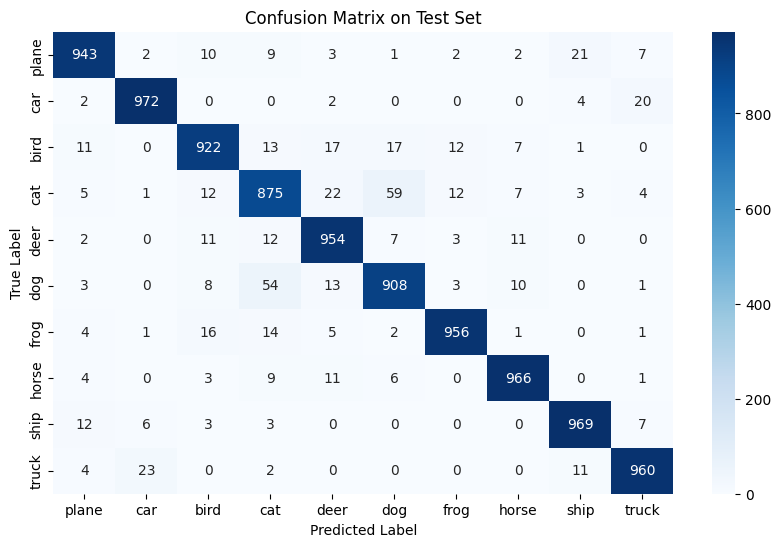

In [ ]:
# --- 7. Evaluasi Rinci dan Visualisasi pada Test Set ---
# Penjelasan:
# Setelah model dilatih, kita evaluasi performanya pada test set
# yang belum pernah dilihat model sebelumnya. Ini memberikan estimasi
# bagaimana model akan berkinerja pada data baru.
# Kita juga akan menampilkan classification report dan confusion matrix.

print("\nMemulai evaluasi akhir pada test set...")
test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

# Classification Report
# Menampilkan precision, recall, f1-score untuk setiap kelas.
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=classes, digits=4))

# Confusion Matrix
# Menunjukkan seberapa sering setiap kelas diklasifikasikan sebagai kelas lain.
print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
# Pastikan variabel cm dan classes sudah ada dari eksekusi kode sebelumnya
# cm = confusion_matrix(test_labels, test_preds)
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("\n--- Akurasi Prediksi per Kelas pada Test Set ---")
if 'cm' in locals() and 'classes' in locals():
    for i, class_name in enumerate(classes):
        correct_predictions = cm[i, i]
        total_samples_in_class = np.sum(cm[i, :]) # Jumlah total sampel aktual untuk kelas i

        if total_samples_in_class > 0:
            accuracy_per_class = correct_predictions / total_samples_in_class
            print(f"Akurasi untuk kelas '{class_name}': {accuracy_per_class:.4f} ({accuracy_per_class*100:.2f}%)")
        else:
            print(f"Akurasi untuk kelas '{class_name}': Tidak ada sampel di test set.")
else:
    print("Variabel 'cm' atau 'classes' belum terdefinisi. Pastikan evaluasi model sudah dijalankan.")


--- Akurasi Prediksi per Kelas pada Test Set ---
Akurasi untuk kelas 'plane': 0.9430 (94.30%)
Akurasi untuk kelas 'car': 0.9720 (97.20%)
Akurasi untuk kelas 'bird': 0.9220 (92.20%)
Akurasi untuk kelas 'cat': 0.8750 (87.50%)
Akurasi untuk kelas 'deer': 0.9540 (95.40%)
Akurasi untuk kelas 'dog': 0.9080 (90.80%)
Akurasi untuk kelas 'frog': 0.9560 (95.60%)
Akurasi untuk kelas 'horse': 0.9660 (96.60%)
Akurasi untuk kelas 'ship': 0.9690 (96.90%)
Akurasi untuk kelas 'truck': 0.9600 (96.00%)


In [ ]:
# Variabel global untuk menyimpan feature maps dari hook
feature_maps_global = None

def hook_fn(module, input, output):
    global feature_maps_global
    feature_maps_global = output

# Fungsi untuk denormalisasi gambar (untuk visualisasi)
# Menggunakan mean dan std yang sama dengan normalisasi awal dari notebook Anda
def denormalize_image(tensor_image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Denormalisasi tensor gambar."""
    tensor_image = tensor_image.clone()
    for t, m, s in zip(tensor_image, mean, std):
        t.mul_(s).add_(m) # Operasi: t * s + m
    return tensor_image

def visualize_predictions_and_feature_maps(model, dataloader, device, classes, num_images_to_show=5, layer_to_hook_name='layer1', show_correct_predictions=False):
    global feature_maps_global # Deklarasi global di awal fungsi
    """
    Visualisasi prediksi, gambar asli, dan feature maps dari layer tertentu,
    untuk gambar yang salah diprediksi atau benar diprediksi.
    """
    was_training = model.training
    model.eval()
    images_shown = 0

    try:
        if hasattr(model, layer_to_hook_name):
            layer_to_hook = getattr(model, layer_to_hook_name)
        elif '[' in layer_to_hook_name and ']' in layer_to_hook_name:
            try:
                parts = layer_to_hook_name.replace(']', '').split('[')
                current_module = model
                for part in parts:
                    if part.isdigit():
                        current_module = current_module[int(part)]
                    else:
                        current_module = getattr(current_module, part)
                layer_to_hook = current_module
            except (AttributeError, IndexError, ValueError) as e:
                print(f"Error mengakses layer '{layer_to_hook_name}': {e}. Menggunakan model.conv1 sebagai fallback.")
                layer_to_hook = model.conv1
                layer_to_hook_name = 'conv1'
        else:
            print(f"Layer '{layer_to_hook_name}' tidak ditemukan secara langsung, menggunakan model.conv1 sebagai fallback.")
            layer_to_hook = model.conv1
            layer_to_hook_name = 'conv1'

        hook_handle = layer_to_hook.register_forward_hook(hook_fn)
    except AttributeError:
        print(f"Tidak dapat menemukan layer dengan nama '{layer_to_hook_name}'. Pastikan nama layer benar. Menggunakan model.conv1 sebagai fallback.")
        layer_to_hook = model.conv1
        layer_to_hook_name = 'conv1'
        hook_handle = layer_to_hook.register_forward_hook(hook_fn)

    prediction_type_str = "BENAR" if show_correct_predictions else "SALAH"
    print(f"\n--- Visualisasi Prediksi {prediction_type_str} dan Feature Maps dari '{layer_to_hook_name}' ---")

    with torch.no_grad():
        for images, labels in dataloader:
            if images_shown >= num_images_to_show:
                break

            images_gpu = images.to(device)
            labels_gpu = labels.to(device)

            outputs_model = model(images_gpu)
            _, preds = torch.max(outputs_model, 1)

            for i in range(images_gpu.size(0)):
                if images_shown >= num_images_to_show:
                    break

                # Tampilkan jika prediksi salah ATAU jika diminta tampilkan prediksi benar
                if (preds[i] != labels_gpu[i] and not show_correct_predictions) or \
                   (preds[i] == labels_gpu[i] and show_correct_predictions):
                    images_shown += 1

                    img_tensor_cpu = images[i].cpu()
                    label_true_cpu = labels[i].cpu()
                    pred_class_cpu = preds[i].cpu()

                    if feature_maps_global is None:
                        print("Feature maps tidak tertangkap. Pastikan hook terpasang dengan benar pada layer yang valid.")
                        continue
                    if feature_maps_global.dim() < 4 or feature_maps_global.size(0) <= i :
                        print(f"Dimensi feature_maps_global ({feature_maps_global.shape if feature_maps_global is not None else 'None'}) tidak sesuai atau indeks {i} di luar batas.")
                        continue

                    current_feature_maps = feature_maps_global[i].cpu()

                    img_display_original = denormalize_image(img_tensor_cpu, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    img_display_original = img_display_original.permute(1, 2, 0).numpy()
                    img_display_original = np.clip(img_display_original, 0, 1)

                    num_feature_maps_to_show = min(8, current_feature_maps.size(0))

                    fig_height = 4
                    fig_width = max(15, 3 * (1 + num_feature_maps_to_show))

                    fig, axs = plt.subplots(1, 1 + num_feature_maps_to_show, figsize=(fig_width, fig_height))
                    if num_feature_maps_to_show == 0 :
                        if not isinstance(axs, np.ndarray):
                           axs_list = [axs]
                        else:
                           axs_list = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
                    else:
                        axs_list = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

                    axs_list[0].imshow(img_display_original)
                    title_color = "green" if show_correct_predictions else "red"
                    axs_list[0].set_title(f"Original Image\nTrue: {classes[label_true_cpu.item()]}\nPred: {classes[pred_class_cpu.item()]}", color=title_color, fontsize=10)
                    axs_list[0].axis('off')

                    for j in range(num_feature_maps_to_show):
                        if j + 1 < len(axs_list):
                            fm_display = current_feature_maps[j].numpy()
                            axs_list[j+1].imshow(fm_display, cmap='viridis')
                            axs_list[j+1].set_title(f"FM {j+1}", fontsize=8)
                            axs_list[j+1].axis('off')
                        else:
                            print(f"Peringatan: Indeks subplot {j+1} di luar batas untuk axs_list (panjang: {len(axs_list)})")

                    plt.suptitle(f"Analisis Prediksi {prediction_type_str} (Contoh ke-{images_shown}) - Feature Maps dari '{layer_to_hook_name}'", fontsize=12, y=1.05 if num_feature_maps_to_show > 2 else 1.1)
                    plt.tight_layout(rect=[0, 0, 1, 0.96])
                    plt.show()

    hook_handle.remove()
    feature_maps_global = None
    model.train(mode=was_training)

# --- Pemanggilan Fungsi ---

# Cetak summary model untuk melihat nama-nama layer yang valid
# Pastikan BATCH_SIZE dan device sudah terdefinisi
# (Anda mungkin sudah mencetaknya di sel sebelumnya, jika belum, uncomment baris berikut)
# print(summary(model, input_size=(BATCH_SIZE, 3, 32, 32), device=str(device)))

# List nama layer yang akan divisualisasikan
SELECTED_LAYER_NAMES_VIS = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']


Visualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: conv1

--- Visualisasi Prediksi SALAH dan Feature Maps dari 'conv1' ---


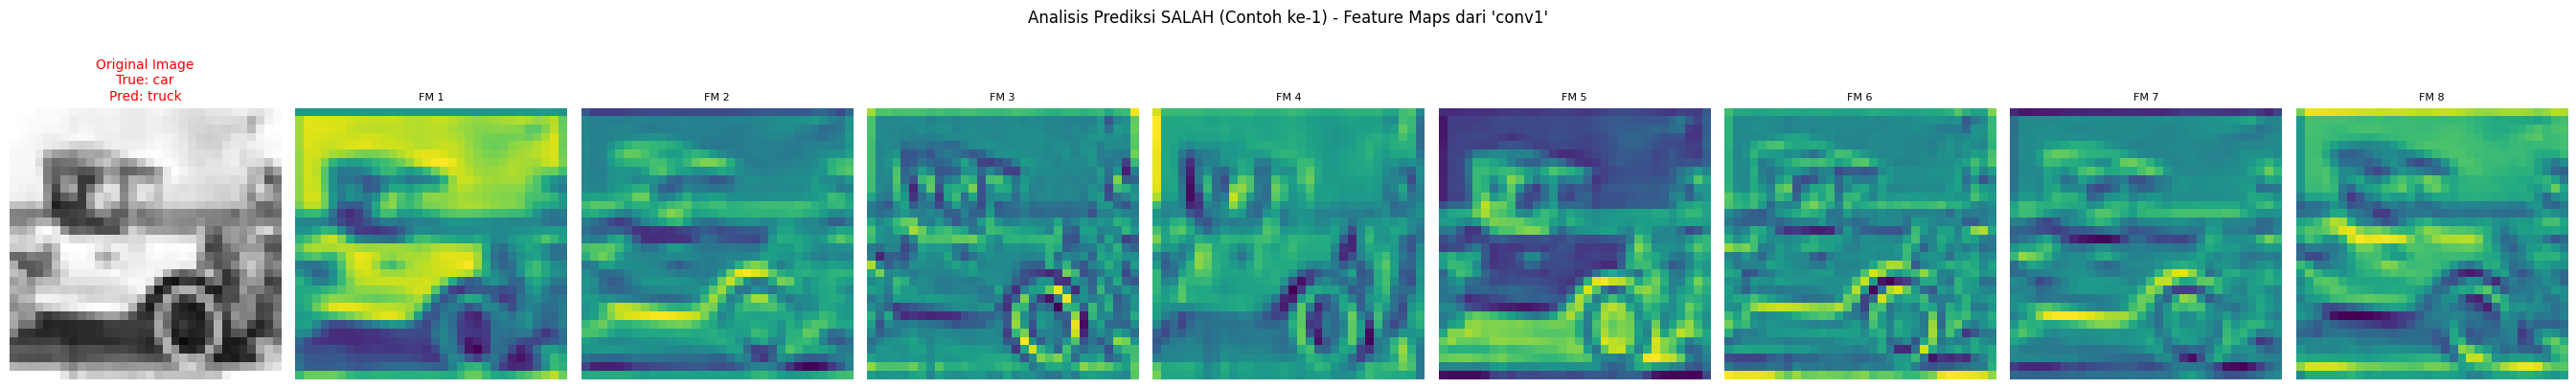

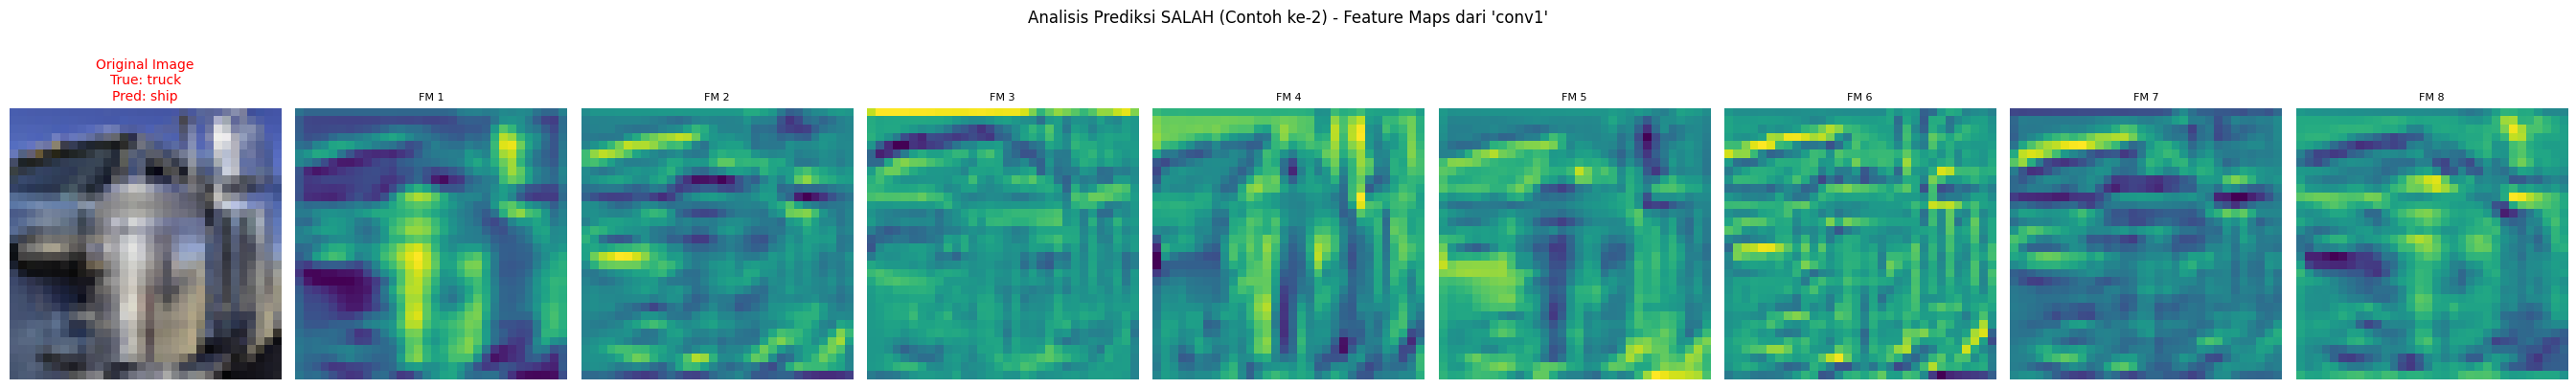


Visualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: layer1

--- Visualisasi Prediksi SALAH dan Feature Maps dari 'layer1' ---


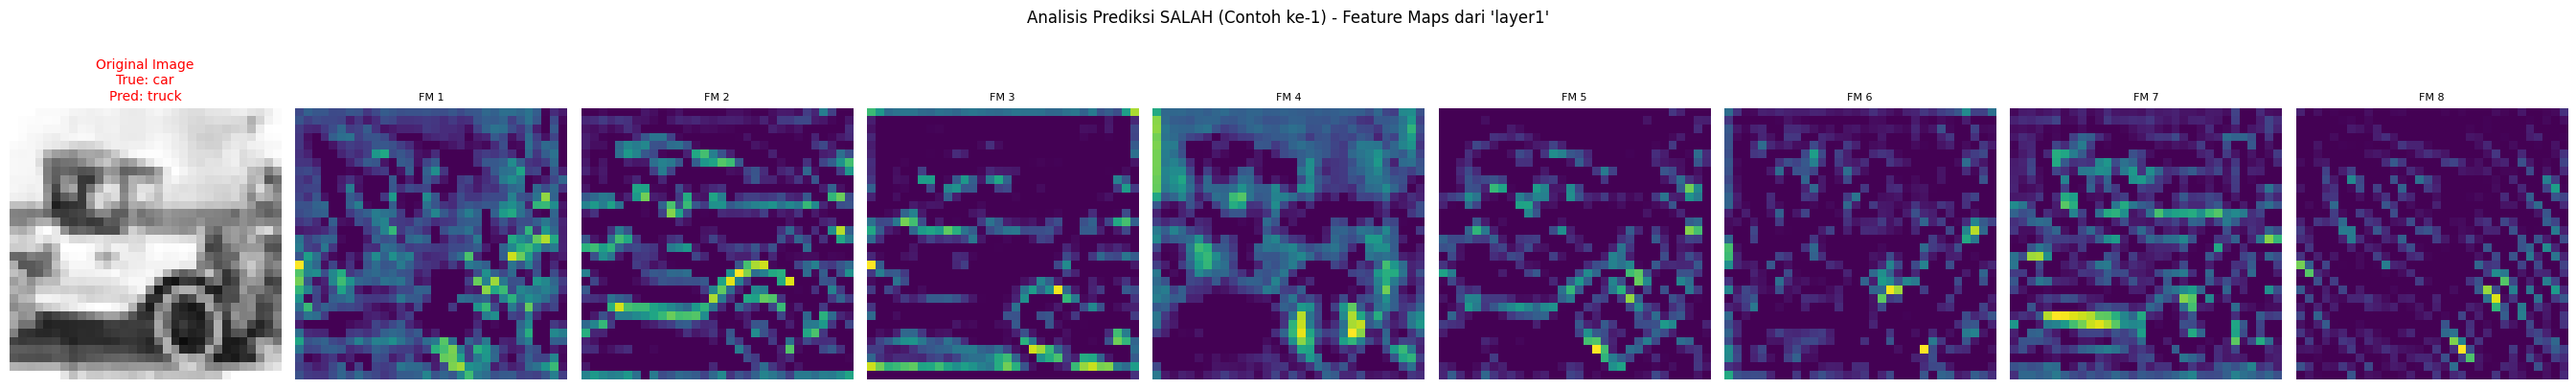

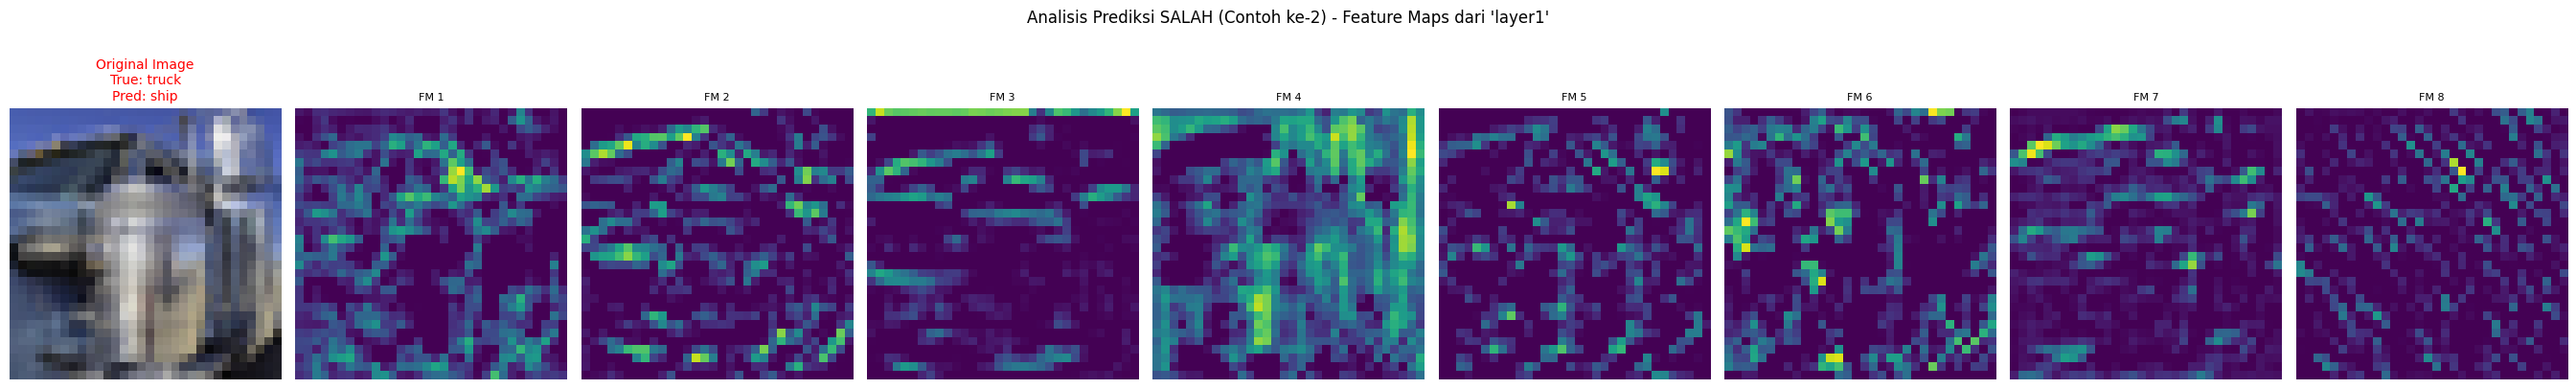


Visualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: layer2

--- Visualisasi Prediksi SALAH dan Feature Maps dari 'layer2' ---


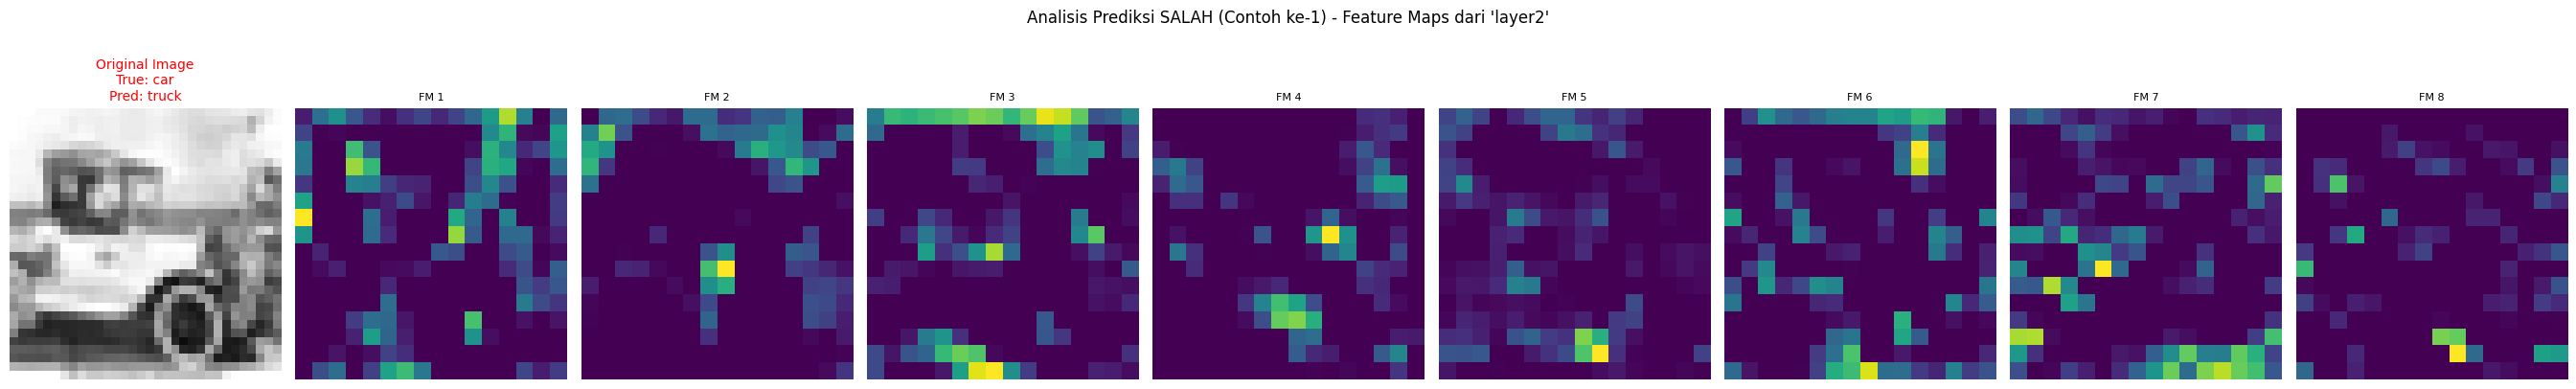

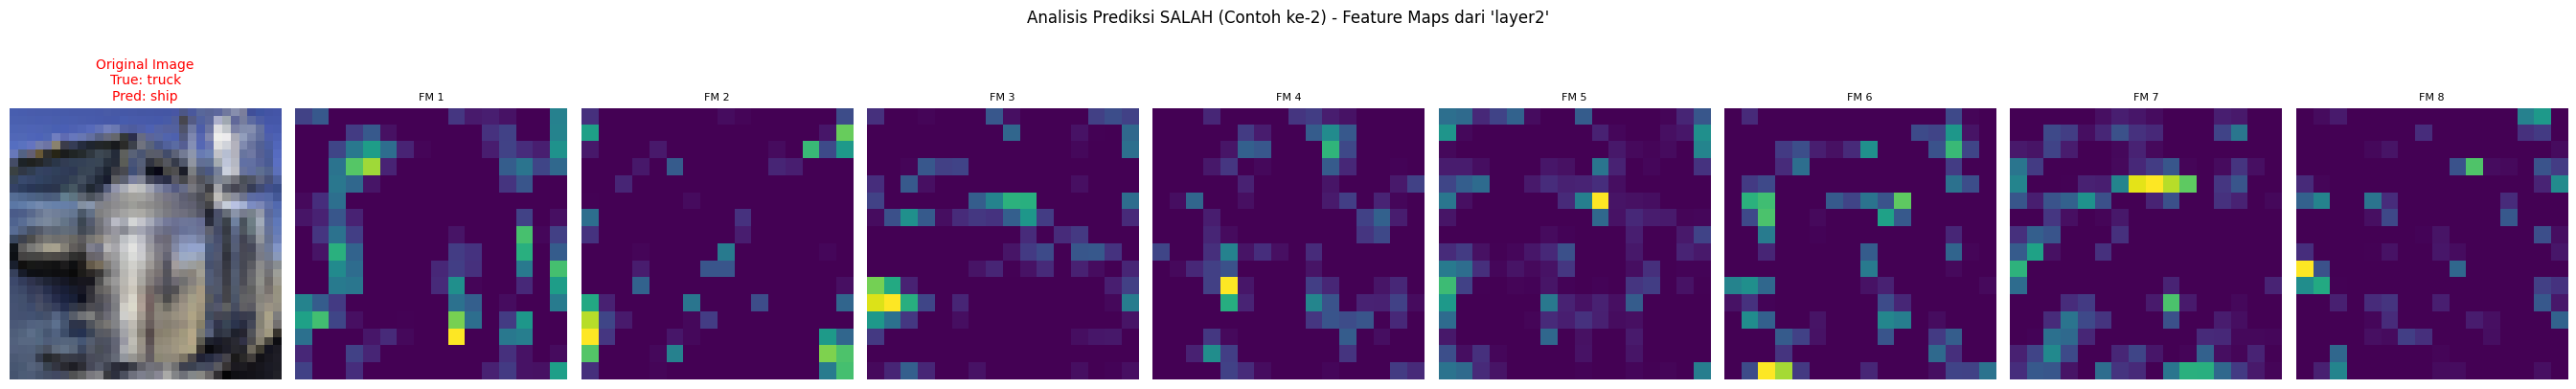


Visualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: layer3

--- Visualisasi Prediksi SALAH dan Feature Maps dari 'layer3' ---


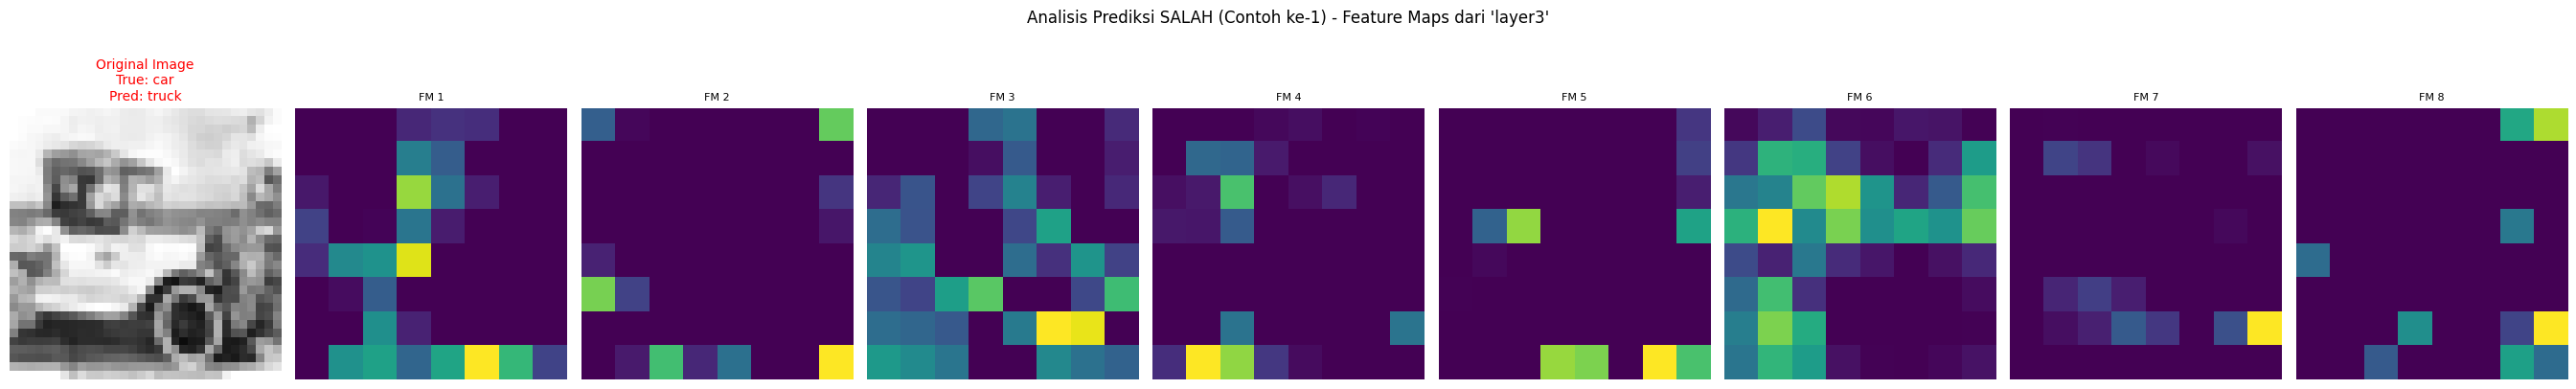

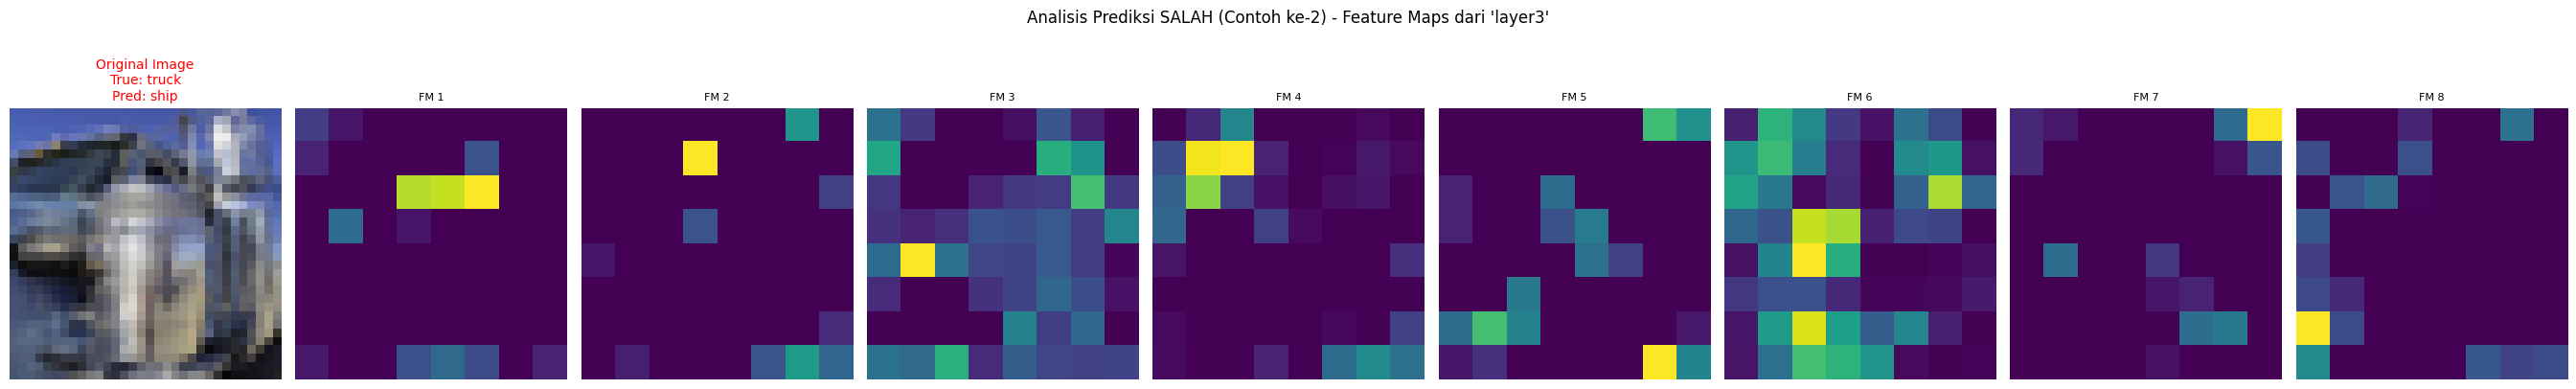


Visualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: layer4

--- Visualisasi Prediksi SALAH dan Feature Maps dari 'layer4' ---


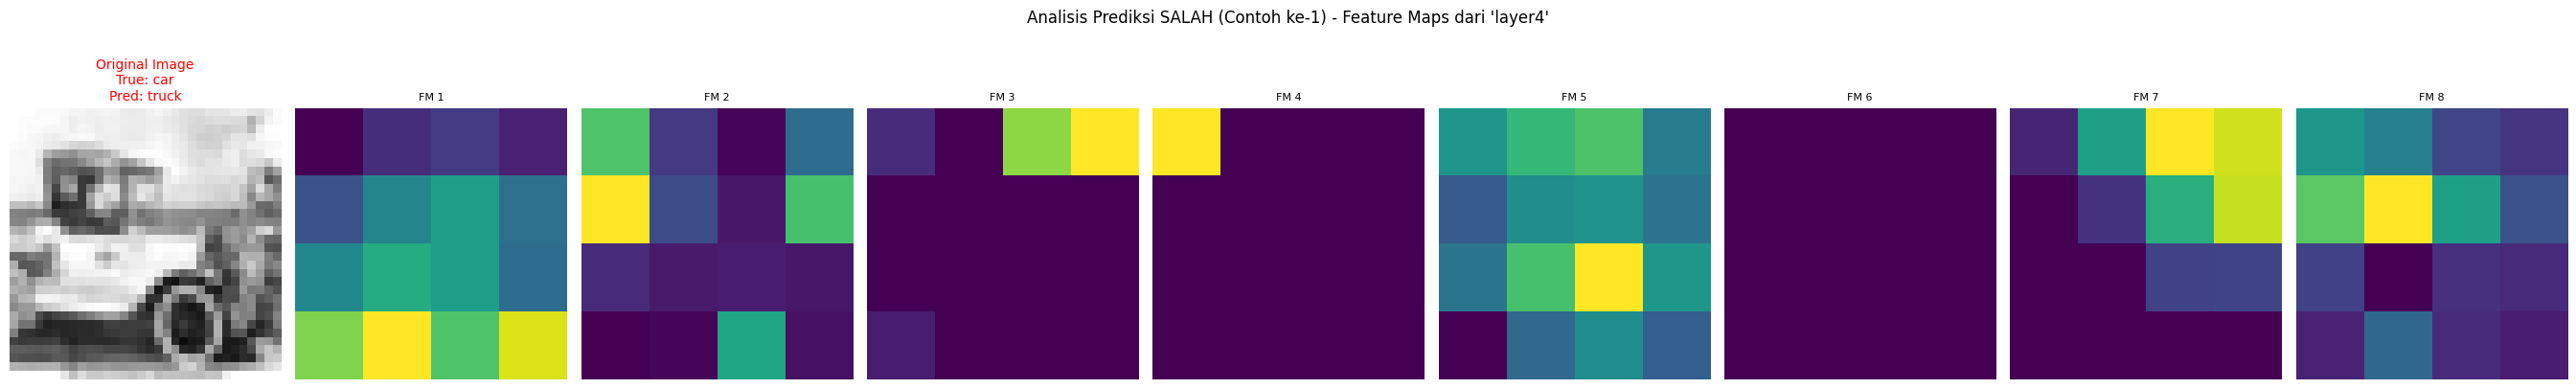

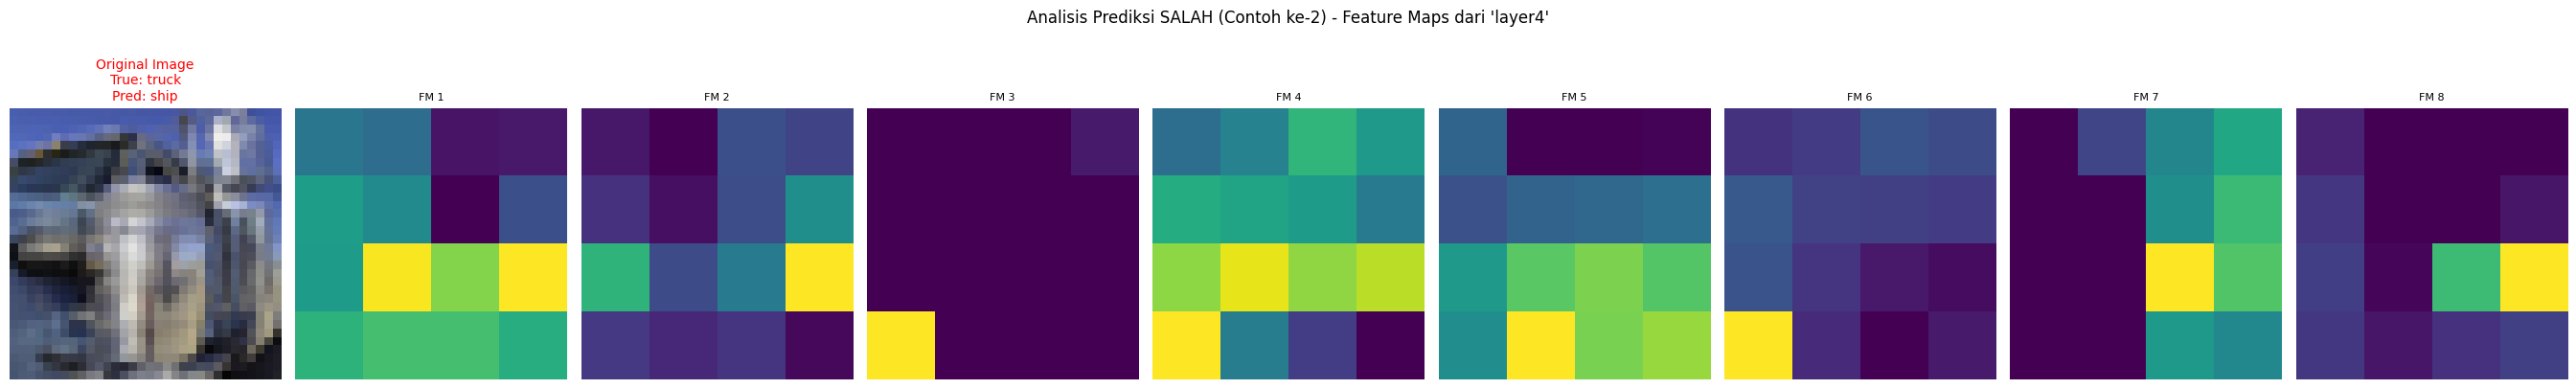

In [ ]:
# Visualisasi untuk prediksi SALAH
for layer_name in SELECTED_LAYER_NAMES_VIS:
    print(f"\nVisualisasi beberapa prediksi SALAH dari test set beserta feature maps dari layer: {layer_name}")
    visualize_predictions_and_feature_maps(model, test_loader, device, classes,
                                           num_images_to_show=2, # Tampilkan 2 contoh kesalahan prediksi
                                           layer_to_hook_name=layer_name,
                                           show_correct_predictions=False)


Visualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: conv1

--- Visualisasi Prediksi BENAR dan Feature Maps dari 'conv1' ---


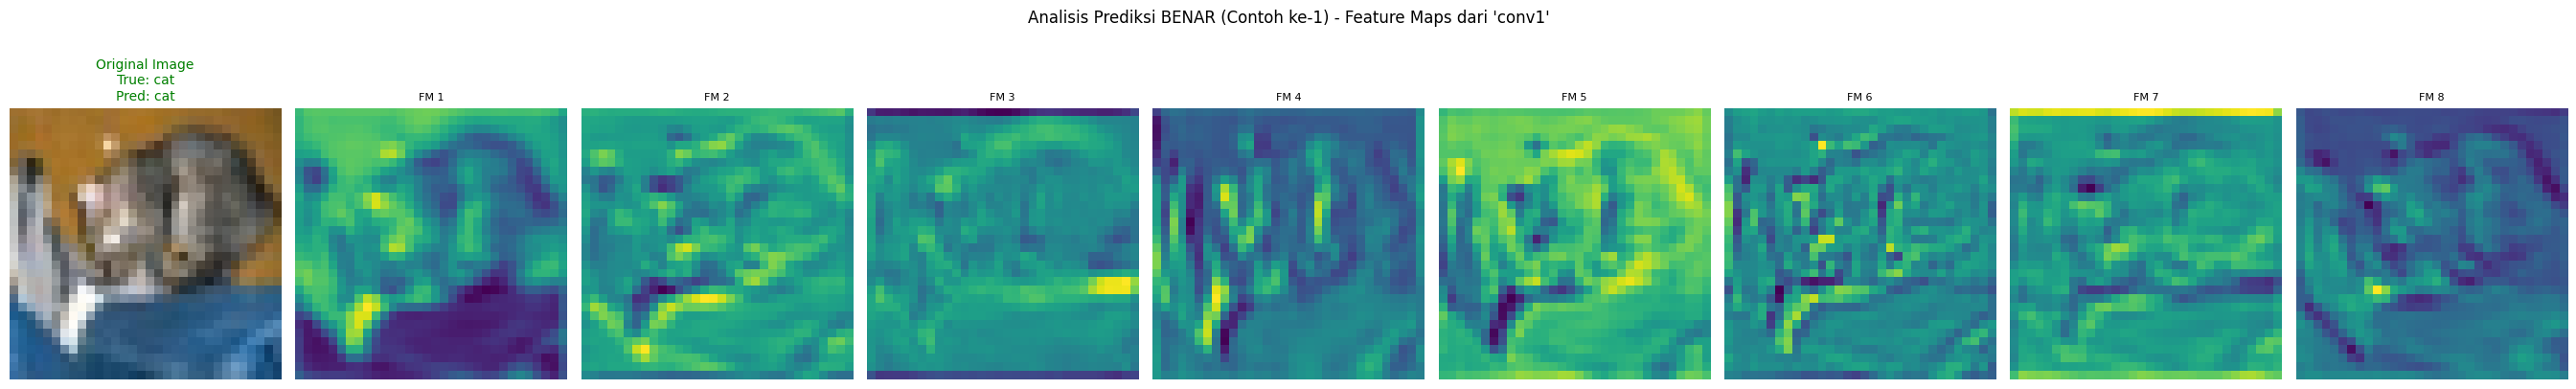

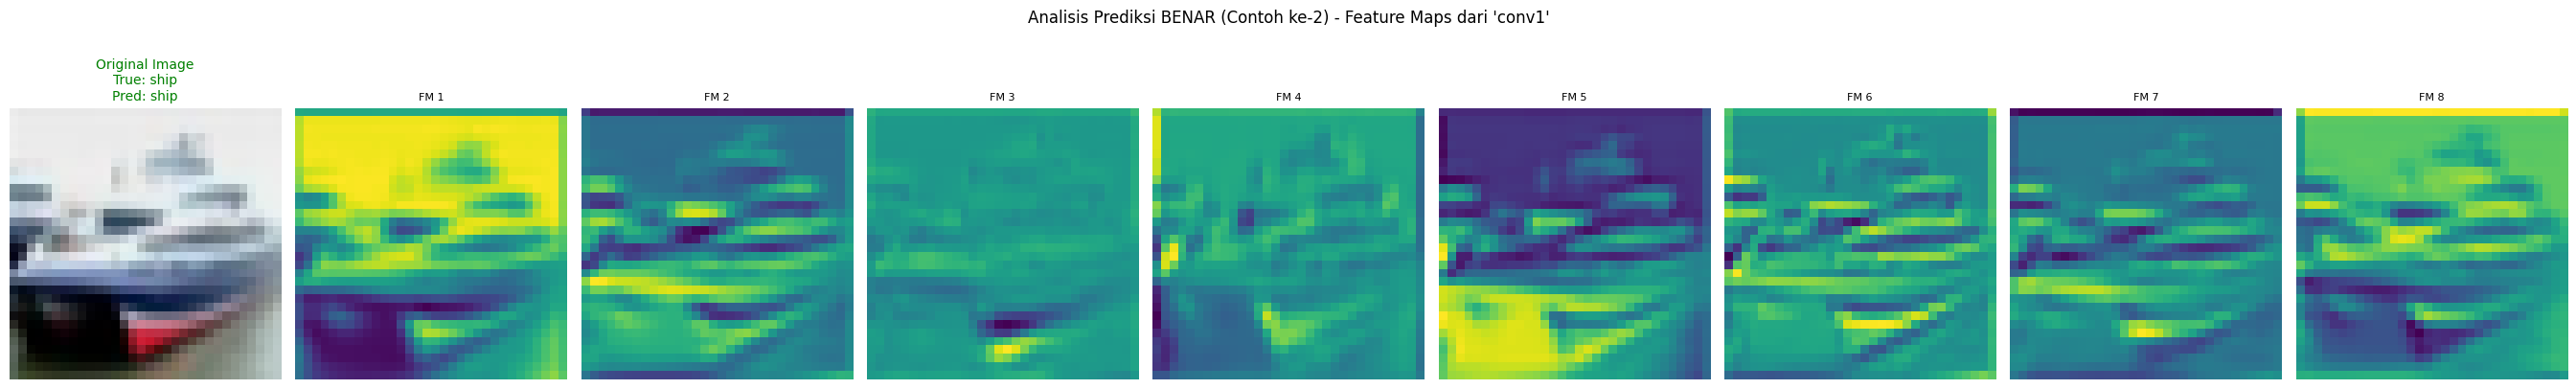


Visualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: layer1

--- Visualisasi Prediksi BENAR dan Feature Maps dari 'layer1' ---


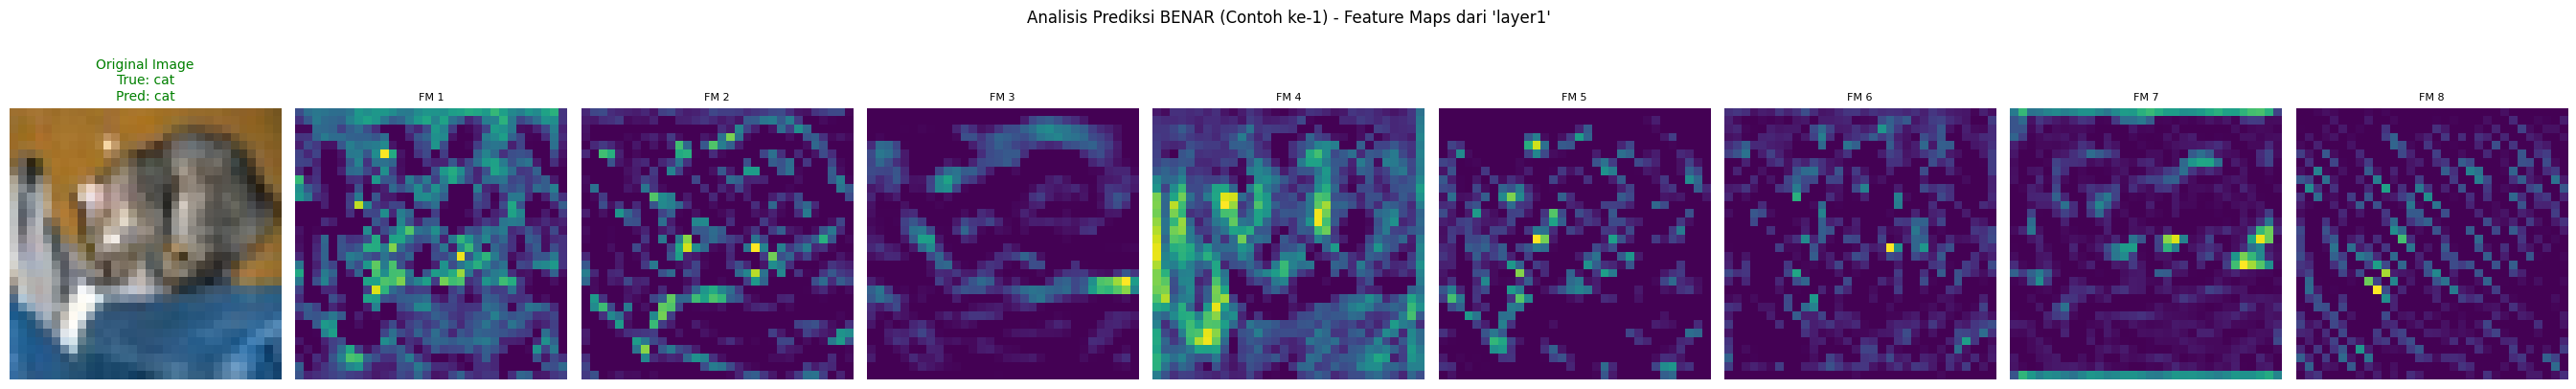

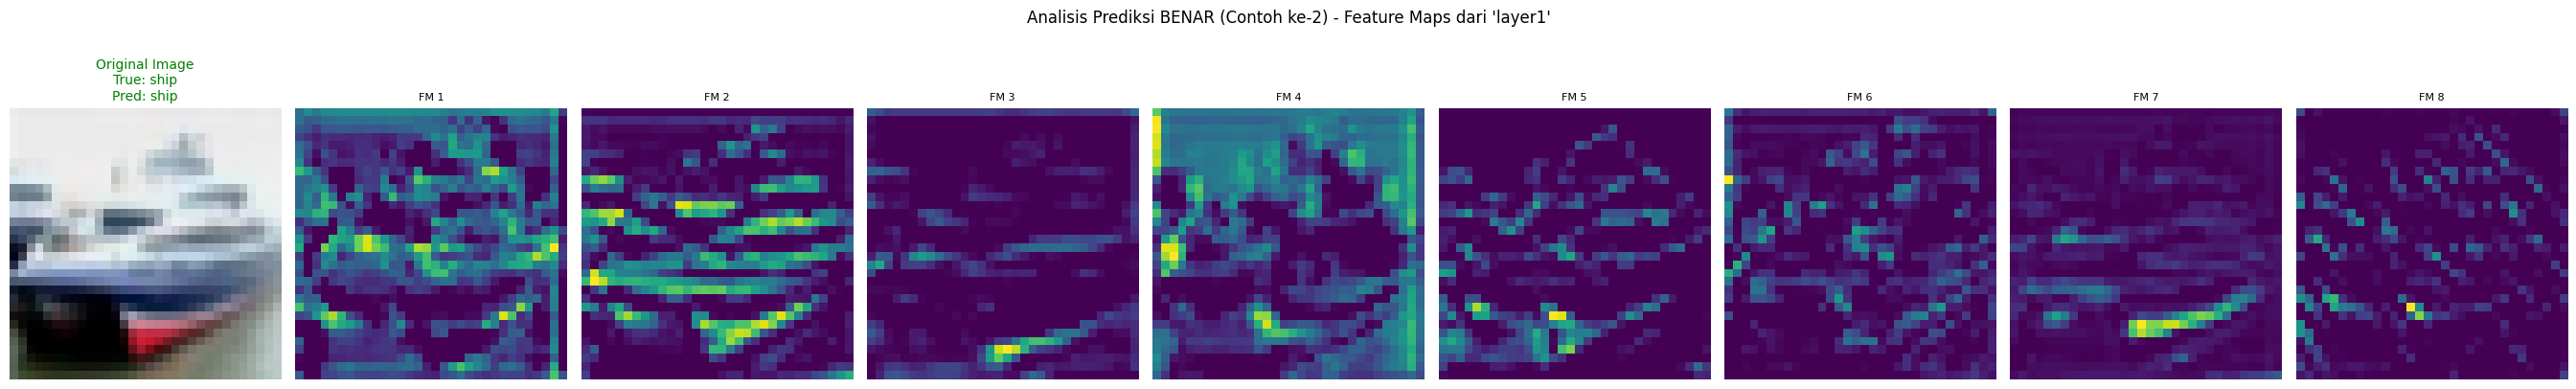


Visualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: layer2

--- Visualisasi Prediksi BENAR dan Feature Maps dari 'layer2' ---


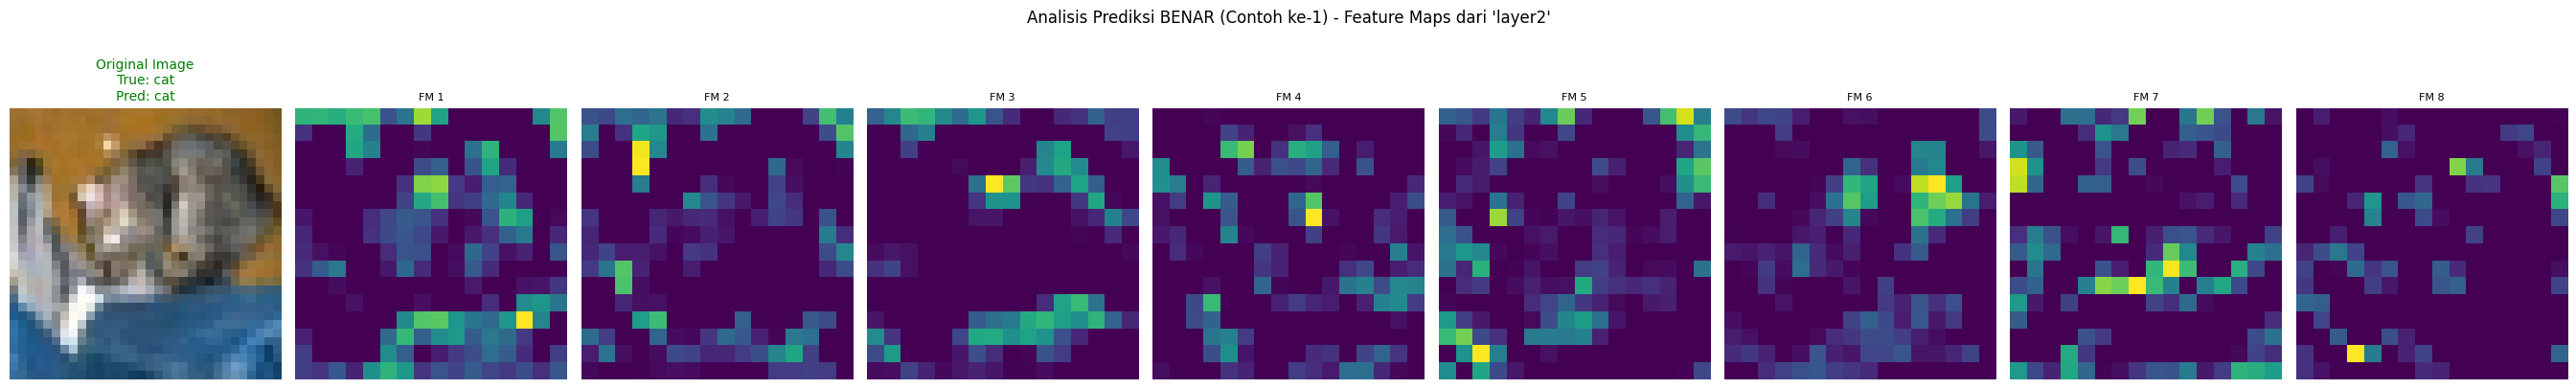

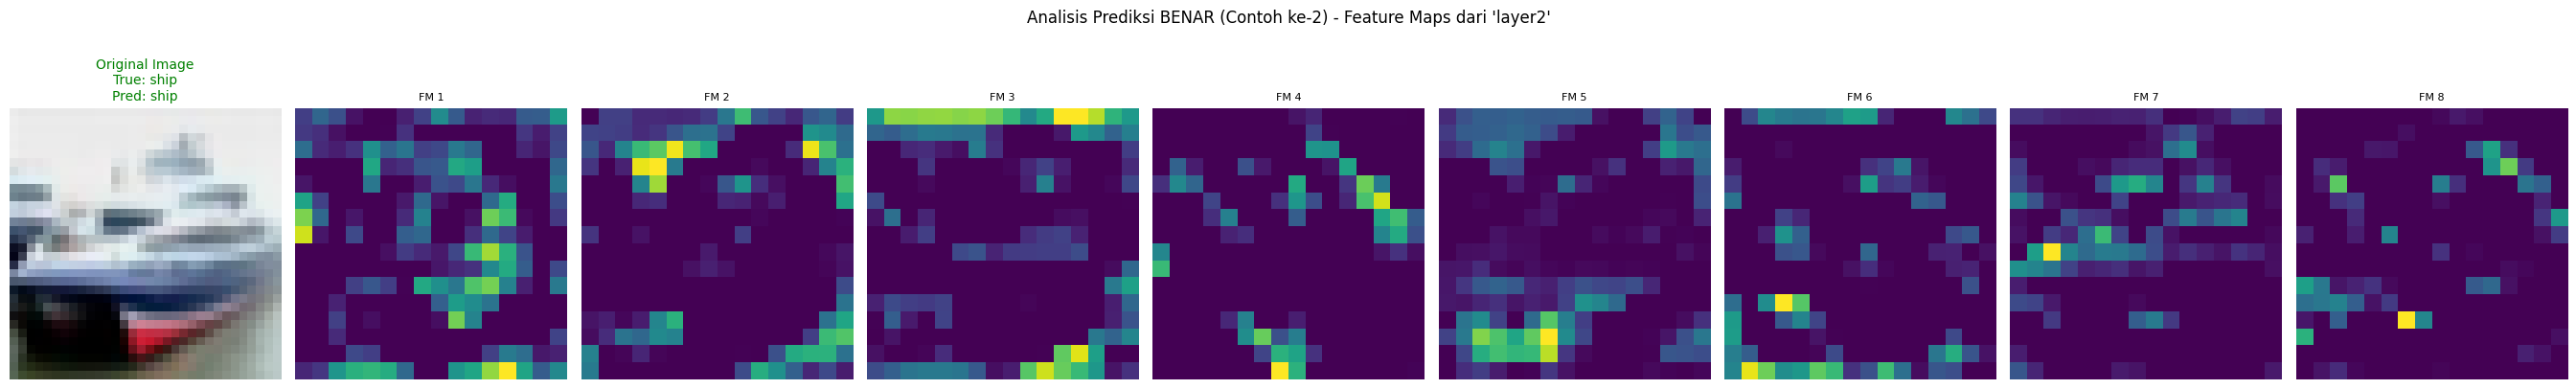


Visualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: layer3

--- Visualisasi Prediksi BENAR dan Feature Maps dari 'layer3' ---


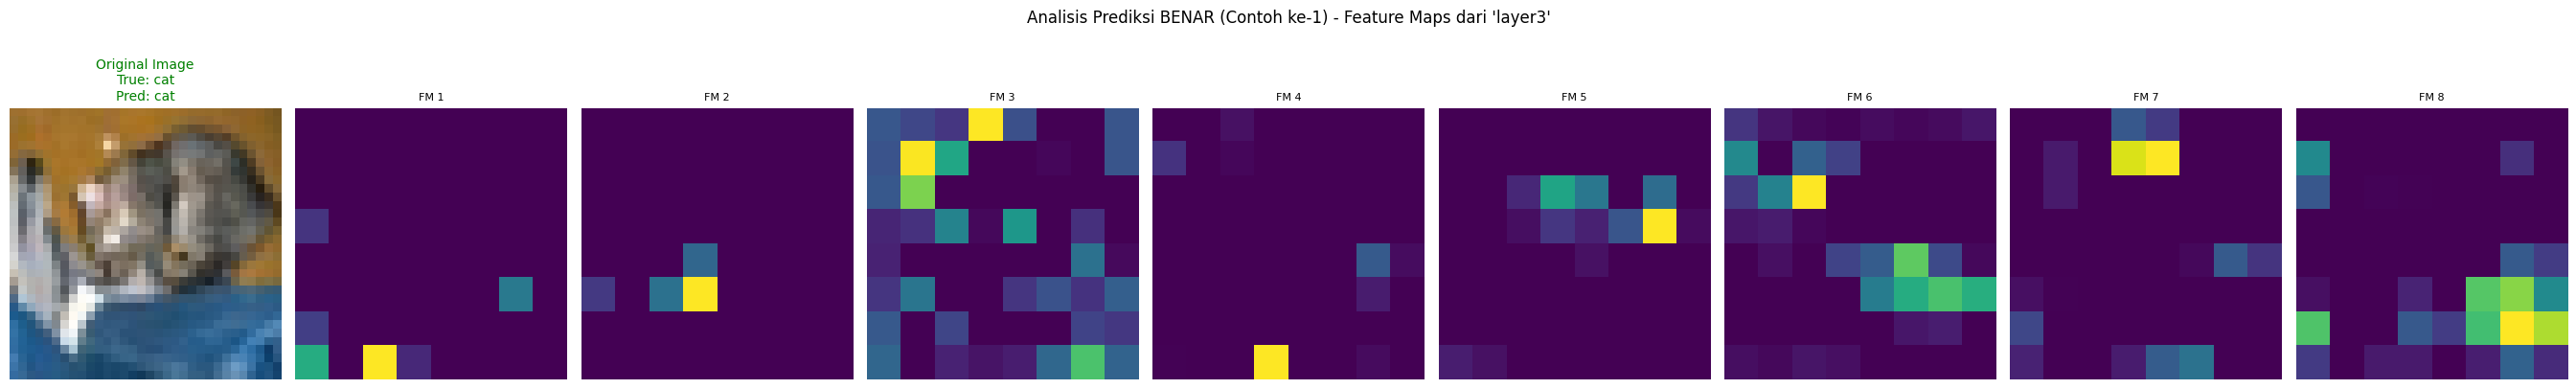

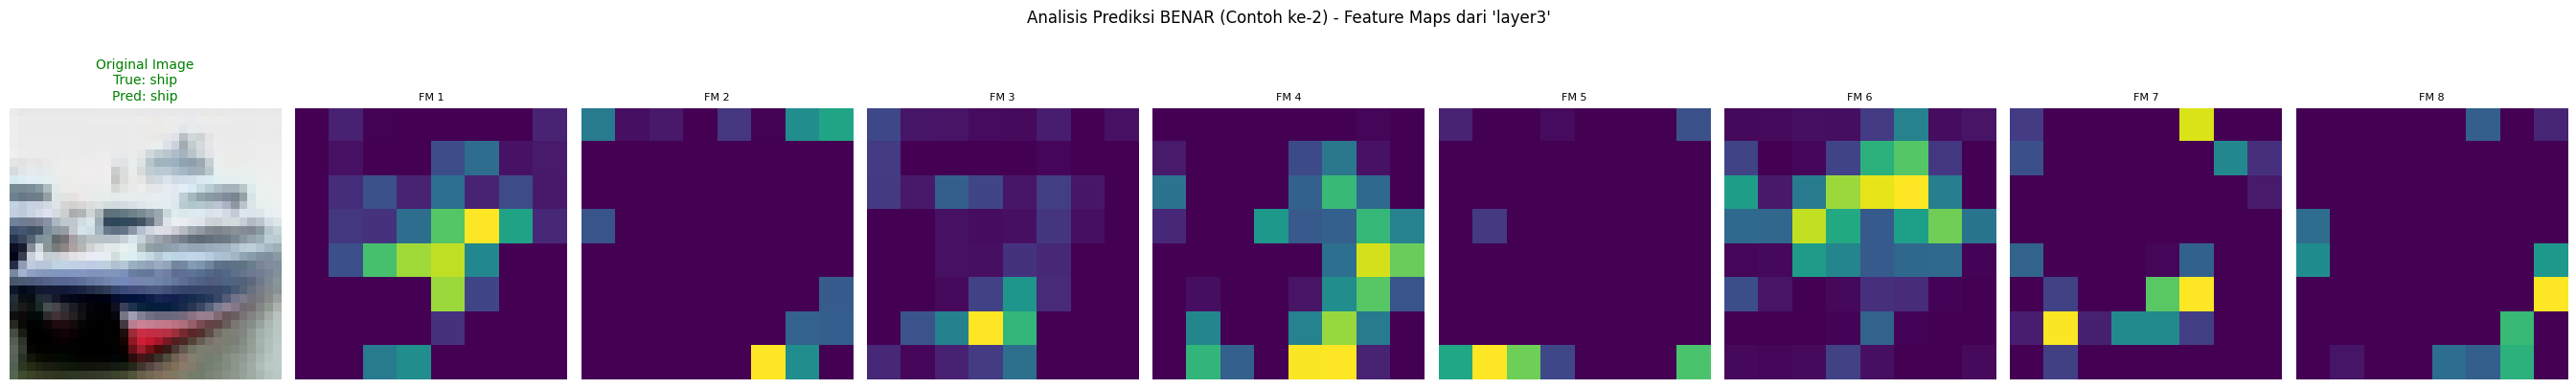


Visualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: layer4

--- Visualisasi Prediksi BENAR dan Feature Maps dari 'layer4' ---


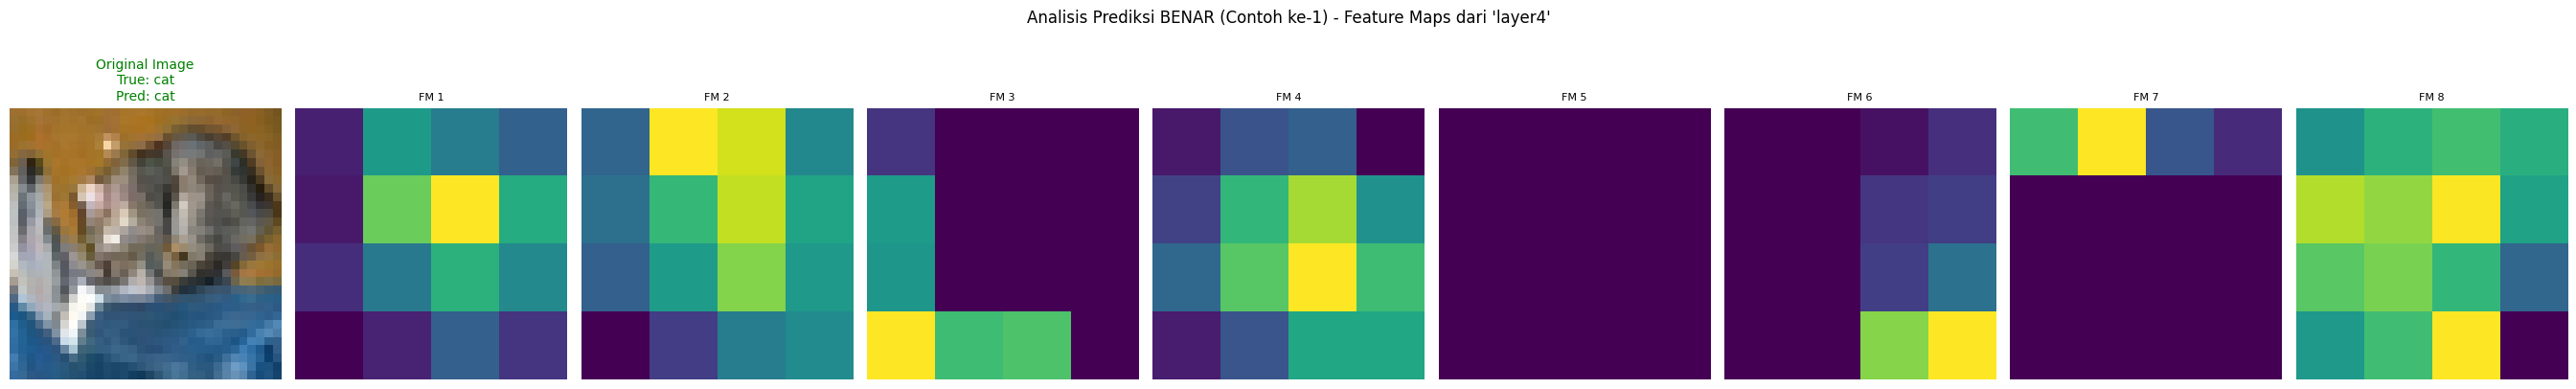

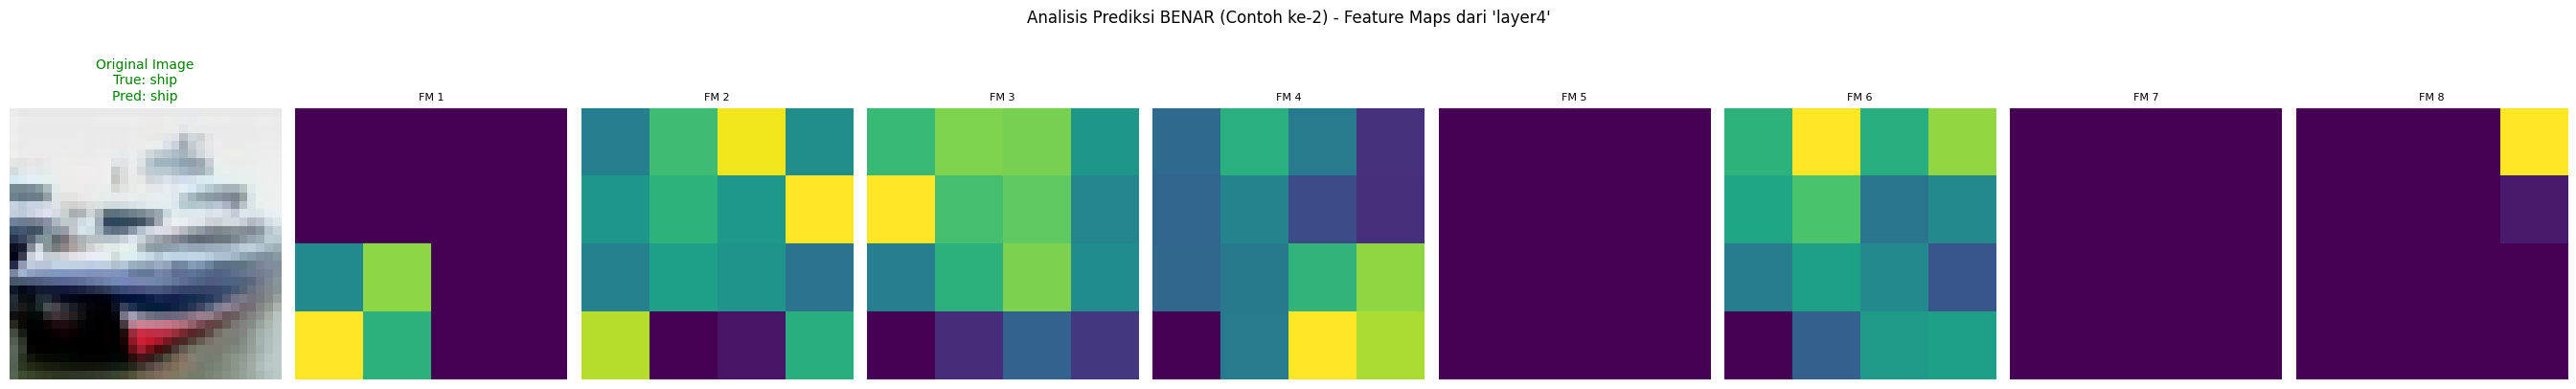

In [ ]:
# Visualisasi untuk prediksi BENAR
for layer_name in SELECTED_LAYER_NAMES_VIS:
    print(f"\nVisualisasi beberapa prediksi BENAR dari test set beserta feature maps dari layer: {layer_name}")
    visualize_predictions_and_feature_maps(model, test_loader, device, classes,
                                           num_images_to_show=2, # Tampilkan 2 contoh prediksi benar
                                           layer_to_hook_name=layer_name,
                                           show_correct_predictions=True)